# Needed libraries

In [1]:
import numpy as np
import os
from sklearn import preprocessing
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.stats import binned_statistic_2d
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, auc
thismodule = sys.modules[__name__]

In [2]:
from read_lhco import read_lhco

In [3]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.lines as mlines
from xgboost import XGBRegressor, XGBClassifier
from scipy.interpolate import bisplrep,bisplev

In [4]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [5]:
import numpy as np
from scipy.optimize import fsolve

def equation(mu, pb_ps, S, B):
    return np.sum(1 / (mu * S + B * pb_ps)) - 1

def find_mu(pb_ps, S, B, mu_guess=1.0):
    mu_solution = fsolve(equation, mu_guess, args=(pb_ps, S, B))
    return mu_solution[0]


In [6]:
BPs2plot = [0,1,2,3,4,5,6,7] # Index (n-1) represent BPn
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
sm_color = 'black'
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

ttjets_color = 'purple'

In [7]:

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Signal events

In [8]:
signal_NLO  = 1.25
luminosidad = 100

cross_section_bps    = np.asarray([185.2, 185.2, 100.5, 100.5, 48.5, 48.5, 26.8, 26.8])
branching_ratios_bps = np.asarray([0.96 , 0.97 , 0.93 , 0.79 , 0.95, 0.96, 0.94, 0.92])

signal_cross = cross_section_bps * branching_ratios_bps *  0.2134 # fb

fid_cross_sections = np.zeros(len(cross_section_bps))
expected_events = np.zeros(len(cross_section_bps))
sim_events = np.zeros(len(cross_section_bps))
cut_events = np.zeros(len(cross_section_bps))

In [38]:
write = False
MET_cut = 100

#bp_number = 1

for bp_number in [1,2,3,4,5,6,7,8]:

    signal_cut_ev  = 0
    signal_init_ev = 0

    counter_bad_jets = 0
    contador_tau     = 0
    signal_runs = os.listdir(f'../data/BP{bp_number}/')
    for ii, file in enumerate(signal_runs):
        print(ii)
        inputevents = read_lhco(f'../data/BP{bp_number}/' + file, OutputType = 'dict')
        signal_init_ev += len(inputevents)
        print('Esta run tuvo ' + str(len(inputevents)) + ' eventos en el lhco')
        
        for i in range(len(inputevents)):
    
            # at least one: photon, jet and lepton (electron or muon)
            if len(inputevents[i]["photon"]) > 0 and len(inputevents[i]["jet"]) > 0 and (len(inputevents[i]["electron"]) > 0 or len(inputevents[i]["muon"]) > 0):
                if inputevents[i]["jet"][0]["pt"] > 100 and -4.5 < inputevents[i]["jet"][0]["eta"] < 4.5:
                    if inputevents[i]["photon"][0]["pt"] > 10 and -2.37 < inputevents[i]["photon"][0]["eta"] < 2.37:
                        if inputevents[i]["met"][0]["pt"] > MET_cut:
    
                            # lepton info
                            if (len(inputevents[i]["electron"]) > 0) and (len(inputevents[i]["muon"]) > 0):
                                if inputevents[i]["electron"][0]["pt"] > inputevents[i]["muon"][0]["pt"]: 
                                    flag = 'electron'
                                    eta_leading_lepton = inputevents[i]["electron"][0]["eta"]
                                else: 
                                    flag = 'muon'
                                    eta_leading_lepton = -2. # Esto es para q el corte sea solo cuando el leading lepton es un electron
                            elif (len(inputevents[i]["electron"]) > 0) and (len(inputevents[i]["muon"]) == 0): 
                                flag = 'electron'
                                eta_leading_lepton = inputevents[i]["electron"][0]["eta"]
                            elif (len(inputevents[i]["muon"]) > 0) and (len(inputevents[i]["electron"]) == 0): 
                                flag = 'muon'
                                eta_leading_lepton = -2. # Esto es para q el corte sea solo cuando el leading lepton es un electron
    
                            if (-2.47 < eta_leading_lepton < -1.52) or (-1.37 < eta_leading_lepton < 1.37) or (1.52 < eta_leading_lepton < 2.47): 
    
                                # how many jets (total) and total hadronic pT
                                flag_bad_jets = 0                            
                                num_jets = 0
                                HT_had = 0 # hadronic activity HT, defined as the scalar sum of the pT of all reconstructed jets
                                HT = 0 # total HT, defined as the scalar sum of the pT of all reconstructed particles
    
                                for j in range(len(inputevents[i]["jet"])):
                                    if (inputevents[i]["jet"][j]["pt"] > 20) and (-4.5 < inputevents[i]["jet"][j]["eta"] < 4.5):
                                        num_jets += 1
                                        HT_had += inputevents[i]["jet"][j]["pt"]
                                        HT += inputevents[i]["jet"][j]["pt"]
                                    if (np.abs(inputevents[i]["jet"][j]["eta"]) > 4.5) or (inputevents[i]["jet"][j]["pt"] < 20):
                                        flag_bad_jets = 1
    
                                # how many photons                         
                                num_photons = 0
                                for j in range(len(inputevents[i]["photon"])):
                                    if inputevents[i]["photon"][j]["pt"] > 10 and -2.37 < inputevents[i]["photon"][j]["eta"] < 2.37:
                                        num_photons = num_photons + 1
                                        HT += inputevents[i]["photon"][j]["pt"]
    
                                # how many muons                        
                                num_muons = 0
                                for j in range(len(inputevents[i]["muon"])):
                                    if inputevents[i]["muon"][j]["pt"] > 10 and -2.7 < inputevents[i]["muon"][j]["eta"] < 2.7:
                                        num_muons = num_muons + 1
                                        HT += inputevents[i]["muon"][j]["pt"]
    
                                # how many electrons                        
                                num_electrons = 0
                                for j in range(len(inputevents[i]["electron"])):
                                    if inputevents[i]["electron"][j]["pt"] > 10:
                                        eta = inputevents[i]["electron"][j]["eta"]
                                        if (-2.47 < eta < -1.52) or (-1.37 < eta < 1.37) or (1.52 < eta < 2.47): 
                                            num_electrons = num_electrons + 1
                                            HT += inputevents[i]["electron"][j]["pt"]
    
                                if flag_bad_jets == 1: counter_bad_jets += 1 
                                if flag_bad_jets == 0:
                                    num_taus = 0
                                    if len(inputevents[i]["tau"]) > 0: 
                                        contador_tau = contador_tau + 1
                                        # how many taus                    
                                        for j in range(len(inputevents[i]["tau"])):
                                            if inputevents[i]["tau"][j]["pt"] > 20:
                                                eta = inputevents[i]["tau"][j]["eta"]
                                                if (-2.47 < eta < -1.52) or (-1.37 < eta < 1.37) or (1.52 < eta < 2.47): 
                                                    num_taus = num_taus + 1
                                                    HT += inputevents[i]["tau"][j]["pt"]
    
                                    if write:                
                                        # photon info:
                                        with open(f'../data/BP{bp_number}/photon_MET_cut.dat', 'a') as f:
                                            f.write('%f %f %f %d\n' % (inputevents[i]["photon"][0]["pt"],inputevents[i]["photon"][0]["eta"],inputevents[i]["photon"][0]["phi"], num_photons))
    
                                        # jet info:
                                        with open(f'../data/BP{bp_number}/jet_MET_cut.dat', 'a') as f:
                                            f.write('%f %f %f\n' % (inputevents[i]["jet"][0]["pt"],inputevents[i]["jet"][0]["eta"],inputevents[i]["jet"][0]["phi"]))
    
                                        # lepton info
                                        num_leptons = num_electrons + num_muons
                                        if flag == 'electron':
                                            with open(f'../data/BP{bp_number}/lepton_MET_cut.dat', 'a') as f:
                                                f.write('%f %f %f %d %d\n' % (inputevents[i]["electron"][0]["pt"],inputevents[i]["electron"][0]["eta"],inputevents[i]["electron"][0]["phi"], num_leptons, num_taus))
                                        else:
                                            with open(f'../data/BP{bp_number}/lepton_MET_cut.dat', 'a') as f:
                                                f.write('%f %f %f %d %d\n' % (inputevents[i]["muon"][0]["pt"],inputevents[i]["muon"][0]["eta"],inputevents[i]["muon"][0]["phi"], num_leptons, num_taus))
    
                                        # MET (eta=0 by def, but I save phi because I have many jets)
                                        with open(f'../data/BP{bp_number}/MET_MET_cut.dat', 'a') as f:
                                            f.write('%f %f %f\n' % (inputevents[i]["met"][0]["pt"],inputevents[i]["met"][0]["eta"],inputevents[i]["met"][0]["phi"]))
    
                                        # hadronic info
                                        with open(f'../data/BP{bp_number}/hadinfo_MET_cut.dat', 'a') as f:
                                            f.write('%f %f %d\n' % (HT, HT_had, num_jets))
    
                                    # total events that passed the cuts
                                    signal_cut_ev += 1
    
    print('Num initial events: ', signal_init_ev)
    print('Total pasaron los cortes: ', signal_cut_ev)
    print('Hay: ', contador_tau, ' taus')
    print('Hay: ', counter_bad_jets, ' eventos con al menos un jet malo')
    
    
    cross       = signal_cross[bp_number-1] * signal_NLO
    aceptancia  = signal_cut_ev / signal_init_ev
    
    signal_fidcross = cross * aceptancia
    signal_expected = cross * aceptancia * luminosidad
    
    fid_cross_sections[bp_number - 1] = signal_fidcross
    expected_events[bp_number - 1] = signal_expected
    sim_events[bp_number - 1] = signal_init_ev
    cut_events[bp_number - 1] = signal_cut_ev
    print('fiducial cross section: ', signal_fidcross)
    print('Events expected: ', signal_expected)

0
Esta run tuvo 100000 eventos en el lhco
1
Esta run tuvo 100000 eventos en el lhco
2
Esta run tuvo 100000 eventos en el lhco
3
Esta run tuvo 100000 eventos en el lhco
4
Esta run tuvo 100000 eventos en el lhco
5
Esta run tuvo 100000 eventos en el lhco
6
Esta run tuvo 100000 eventos en el lhco
7
Esta run tuvo 100000 eventos en el lhco
8
Esta run tuvo 100000 eventos en el lhco
9
Esta run tuvo 100000 eventos en el lhco
10
Esta run tuvo 100000 eventos en el lhco
11
Esta run tuvo 100000 eventos en el lhco
12
Esta run tuvo 100000 eventos en el lhco
13
Esta run tuvo 100000 eventos en el lhco
14
Esta run tuvo 100000 eventos en el lhco
15
Esta run tuvo 100000 eventos en el lhco
16
Esta run tuvo 100000 eventos en el lhco
17
Esta run tuvo 100000 eventos en el lhco
18
Esta run tuvo 100000 eventos en el lhco
19
Esta run tuvo 100000 eventos en el lhco
20
Esta run tuvo 100000 eventos en el lhco
Num initial events:  2100000
Total pasaron los cortes:  344465
Hay:  4809  taus
Hay:  3155  eventos con al 

In [39]:
print('Fid cross sections: ', fid_cross_sections)
print('Expected events: ', expected_events)
print('Simulated events: ', sim_events)
print('Number of events after cuts: ', cut_events)

Fid cross sections:  [0.         0.         0.         0.         0.         0.
 0.         1.07882961]
Expected events:  [  0.           0.           0.           0.           0.
   0.           0.         107.88296054]
Simulated events:  [1900000. 2300000. 2500000. 2000000. 2597448. 2398994. 2300000. 2100000.]
Number of events after cuts:  [257030. 279473. 279659. 279491. 374847. 372682. 317450. 344465.]


# Analysis (MET > 100)

## Reading SM data

In [10]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

wgamma_cross = 0.944 * 1000 #[fb]
wgamma_NLO   = 2.37 # k-factor [14 TeV]

wjets_cross = 168.12 * 1000 #[fb]
wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [11]:
wgamma_fidcross  = 584.6234
wjets_fidcross   = 600.5788
ttgamma_fidcross = 24.98413

ttjets_fidcross  = 180.510721
zjets_fidcross   = 33.609922
wz_fidcross      = 6.740334
zz_fidcross      = 0.843997
ww_fidcross      = 15.8203
tj_fidcross      = 7.9070
tb_fidcross      = 11.52578
tw_fidcross      = 12.72042

bkg = ['wgamma', 'wjets', 'ttgamma',
       'zjets',
       'ttjets',
       'tj', 'tb', 'tw',
       'ww', 'zz', 'wz'
      ]

B_fidcross_tot = 0
for i, ibkg in enumerate(bkg):
    B_fidcross_tot = B_fidcross_tot + globals()[ibkg + '_fidcross']
B_fidcross_tot

1479.8648040000003

In [12]:
wgamma_aceptancia_init  = wgamma_fidcross / (wgamma_cross * wgamma_NLO)
wjets_aceptancia_init   = wjets_fidcross / (wjets_cross * wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [13]:
wgamma_expected  = 58462.34
wjets_expected   = 60057.88
ttgamma_expected = 2498.413

ttjets_expected  = 18051.0721
zjets_expected   = 3360.9922
wz_expected      = 674.0334
zz_expected      = 84.3997
ww_expected      = 1582.03
tj_expected      = 790.70
tb_expected      = 1152.578
tw_expected      = 1272.042

B_expected = 0
for i, ibkg in enumerate(bkg):
    B_expected = B_expected + globals()[ibkg + '_expected']
B_expected

147986.4804

In [14]:
sample = 200_000 # Number of signal and background events to train and validate

wgamma_sample  = int(round(sample * wgamma_fidcross / B_fidcross_tot))
wjets_sample   = int(round(sample * wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(wgamma_sample)
print(wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

79010
81167
3377
24396
4542
911
114
2138
1069
1558
1719


In [15]:
datFolderwgamma  = '../../susyatLHC/data/Wgamma/'
datFolderwjets   = '../../susyatLHC/data/Wjets/'
datFolderttgamma = '../../susyatLHC/data/ttGamma/'
datFolderttjets  = '../../susyatLHC/data/ttjets/'
datFolderzjets   = '../../susyatLHC/data/Zlep+j/'
datFolderwz      = '../../susyatLHC/data/wz/'
datFolderww      = '../../susyatLHC/data/ww/'
datFolderzz      = '../../susyatLHC/data/zz/'
datFoldertj      = '../../susyatLHC/data/singleTop+j/'
datFoldertb      = '../../susyatLHC/data/singleTop+b/'
datFoldertw      = '../../susyatLHC/data/singleTop+W/'

for i, ibkg in enumerate(bkg):
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'photon_4.dat', delimiter=' ')
    setattr(thismodule, 'photon_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'jet_4.dat', delimiter=' ')
    setattr(thismodule, 'jet_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'lepton_4.dat', delimiter=' ')
    setattr(thismodule, 'lepton_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'MET_4.dat', delimiter=' ')
    setattr(thismodule, 'MET_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'hadinfo_4.dat', delimiter=' ')
    setattr(thismodule, 'hadinfo_' + ibkg, aux)

In [16]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM  = globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]
        jet_SM     = globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]
        lepton_SM  = globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]
        MET_SM     = globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]
        hadinfo_SM = globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]
    else:
        photon_SM  = np.concatenate([photon_SM, globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]])
        jet_SM     = np.concatenate([jet_SM, globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]])
        lepton_SM  = np.concatenate([lepton_SM, globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]])
        MET_SM     = np.concatenate([MET_SM, globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]])
        hadinfo_SM = np.concatenate([hadinfo_SM, globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]])

In [17]:
bkg_flag = np.zeros(len(photon_SM))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag[:globals()[ibkg + '_sample']] = i + 1
        end_ind = globals()[ibkg + '_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_sample']
        bkg_flag[(init_ind):(end_ind)] = i + 1

In [18]:
wjets_pool  = len(photon_wjets[wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / wjets_fidcross)

wgamma_pool_sample  = int(round(pool_sample * wgamma_fidcross / B_fidcross_tot))
wjets_pool_sample   = int(round(pool_sample * wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(wgamma_pool_sample)
print(wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

173444
178178
7412
53553
9971
2000
250
4694
2346
3419
1719


In [19]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM_pool  = globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        jet_SM_pool     = globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        lepton_SM_pool  = globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        MET_SM_pool     = globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        hadinfo_SM_pool = globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
    else:
        photon_SM_pool  = np.concatenate([photon_SM_pool, globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        jet_SM_pool     = np.concatenate([jet_SM_pool, globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        lepton_SM_pool  = np.concatenate([lepton_SM_pool, globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        MET_SM_pool     = np.concatenate([MET_SM_pool, globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        hadinfo_SM_pool = np.concatenate([hadinfo_SM_pool, globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])

In [20]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag_pool[:globals()[ibkg + '_pool_sample']] = i + 1
        end_ind = globals()[ibkg + '_pool_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_pool_sample']
        bkg_flag_pool[(init_ind):(end_ind)] = i + 1

In [21]:
print(photon_wjets.shape)
print(photon_ttgamma.shape)
print(photon_wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(259345, 4)
(2710879, 4)
(3579946, 4)
(92997, 4)
(15123, 4)
(9246, 4)
(2501, 4)
(27629, 4)
(4804, 4)
(5969, 4)
(17655, 4)


### Other variables

In [22]:
for i, ibkg in enumerate(bkg):
    aux = globals()['photon_' + ibkg][:,0] + globals()['lepton_' + ibkg][:,0] + globals()['jet_' + ibkg][:,0]
    setattr(thismodule, 'ST_' + ibkg, aux)
    
    aux = np.divide( globals()['MET_' + ibkg][:,0], np.sqrt(globals()['hadinfo_' + ibkg][:,0]) )
    setattr(thismodule, 'MET_sig_' + ibkg, aux)
    
    aux = globals()['MET_' + ibkg][:,0] + globals()['photon_' + ibkg][:,0] + globals()['lepton_' + ibkg][:,0] + globals()['jet_' + ibkg][:,0]
    setattr(thismodule, 'm_eff_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['photon_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_photon_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_jet_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['lepton_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_lepton_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['photon_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_photon_' + ibkg])) )
    setattr(thismodule, 'mT_photon_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['jet_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_jet_' + ibkg])) )
    setattr(thismodule, 'mT_jet_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['lepton_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_lepton_' + ibkg])) )
    setattr(thismodule, 'mT_lepton_' + ibkg, aux)
    
    aux = np.absolute( globals()['photon_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_photon_jet_' + ibkg, aux)    
    globals()['phi_photon_jet_' + ibkg][globals()['phi_photon_jet_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_photon_jet_' + ibkg][globals()['phi_photon_jet_' + ibkg] > np.pi]
    
    aux = np.absolute( globals()['photon_' + ibkg][:,2] - globals()['lepton_' + ibkg][:,2] )
    setattr(thismodule, 'phi_photon_lepton_' + ibkg, aux)    
    globals()['phi_photon_lepton_' + ibkg][globals()['phi_photon_lepton_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_photon_lepton_' + ibkg][globals()['phi_photon_lepton_' + ibkg] > np.pi]
        
    aux = np.absolute( globals()['lepton_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_lepton_jet_' + ibkg, aux)    
    globals()['phi_lepton_jet_' + ibkg][globals()['phi_lepton_jet_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_lepton_jet_' + ibkg][globals()['phi_lepton_jet_' + ibkg] > np.pi]
    
    aux = np.sqrt( (globals()['photon_' + ibkg][:,1] - globals()['jet_' + ibkg][:,1])**2 + (globals()['phi_photon_jet_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_photon_jet_' + ibkg, aux)  
    
    aux = np.sqrt( (globals()['photon_' + ibkg][:,1] - globals()['lepton_' + ibkg][:,1])**2 + (globals()['phi_photon_lepton_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_photon_lepton_' + ibkg, aux)
    
    aux = np.sqrt( (globals()['lepton_' + ibkg][:,1] - globals()['jet_' + ibkg][:,1])**2 + (globals()['phi_lepton_jet_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_lepton_jet_' + ibkg, aux)

In [23]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [24]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## Reading NP data

In [40]:
datFolderNP = '../data/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/photon_100.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/jet_100.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/lepton_100.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/MET_100.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/hadinfo_100.dat', delimiter=' ') )

In [41]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (200001, 5)
BP1 (257030, 5)
BP2 (279473, 5)
BP3 (279659, 5)
BP4 (279491, 5)
BP5 (374847, 5)
BP6 (372682, 5)
BP7 (317450, 5)
BP8 (344465, 5)


In [42]:
jet_NP[7].shape

(344465, 3)

In [43]:
signal_NLO  = 1.25
luminosidad = 100


cross_section_bps    = np.asarray([185.2, 185.2, 100.5, 100.5, 48.5, 48.5, 26.8, 26.8])
branching_ratios_bps = np.asarray([0.96 , 0.97 , 0.93 , 0.79 , 0.95, 0.96, 0.94, 0.92])

signal_cross = cross_section_bps * branching_ratios_bps *  0.2134 # fb

sim_events = np.asarray([1_900_000., 2_300_000., 2_500_000., 2_000_000., 2_597_448., 2_398_994., 2_300_000., 2_100_000.])
cut_events = np.asarray([257_030.  , 279_473.  , 279_659.  , 279_491.  , 374_847.  , 372_682.  , 317_450.  , 344_465.])

cross       = signal_cross * signal_NLO
aceptancia  = cut_events / sim_events
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [6.41574152 5.8227637  2.78895964 2.95961632 1.77368686 1.92941946
 0.92750139 1.07882961]
Events expected:  [641.57415224 582.27636959 278.8959644  295.96163172 177.36868635
 192.94194642  92.75013942 107.88296054]


In [44]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

## Plots

In [26]:
BPs2plot = [0,1,2,3,4,5,6,7] # Index (n-1) represent BPn
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
sm_color = 'black'
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

ttjets_color = 'purple'

In [30]:
sm_color = (1.0, 0.498, 0.314)
wjets_color = 'gray'
wgamma_color = 'gray'
ttgamma_color = 'gray'
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')

In [31]:
bkg_labels = ['W + jets', '$W \ \\gamma$', '$t \\bar{t}$ + jets', 'Z + jets', 'Single-top', '$t \\bar{t} \ \\gamma$', 'Diboson']
cmap = plt.cm.get_cmap('Reds', 8)
colors = [mpl.colors.to_hex(cmap(i+1)) for i in range(len(bkg_labels))]
cmap = cm.get_cmap('Blues', 18)

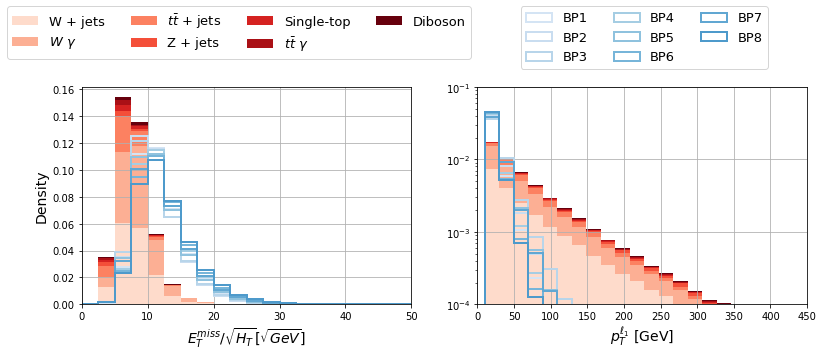

In [37]:
fig,ax = plt.subplots(1,2, figsize = (13,4))

# MET sig -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 20 
bin_range = [0,50]

bkg_list = [MET_sig_wjets[:wjets_sample], MET_sig_wgamma[:wgamma_sample], MET_sig_ttjets[:ttjets_sample],
            MET_sig_zjets[:zjets_sample], 
            np.concatenate((MET_sig_tj[:tj_sample], MET_sig_tb[:tb_sample], MET_sig_tw[:tw_sample])), 
            MET_sig_ttgamma[:ttgamma_sample], 
            np.concatenate((MET_sig_zz[:zz_sample], MET_sig_wz[:wz_sample], MET_sig_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.20, 1.4), ncol = 4) 

for i in BPs2plot:
    ax[ncol].hist(MET_sig_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$E_{T}^{miss} / \sqrt{H_{T}} [\sqrt{GeV}]$",fontsize=14)
ax[ncol].set_ylabel("Density",fontsize=14)
#ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,50)
#ax[ncol].set_ylim(5e-5,1)

# Pt lepton -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins  = 50
bin_range = [10,1000]

bkg_list = [lepton_wjets[:wjets_sample,0], lepton_wgamma[:wgamma_sample,0], lepton_ttjets[:ttjets_sample,0],
            lepton_zjets[:zjets_sample,0],
            np.concatenate((lepton_tj[:tj_sample,0], lepton_tb[:tb_sample,0], lepton_tw[:tw_sample,0])), 
            lepton_ttgamma[:ttgamma_sample,0], 
            np.concatenate((lepton_zz[:zz_sample,0], lepton_wz[:wz_sample,0], lepton_ww[:ww_sample,0]))]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)


for i in BPs2plot:
    ax[ncol].hist(lepton_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, label = 'BP'+ str(i+1))
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(0.9, 1.4), ncol = 3)


ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_ylim(1e-4,0.1)
ax[ncol].set_xlim(0,450)

plt.savefig('../graph/MET_sig_PT_lepton_dist.pdf', bbox_inches='tight')

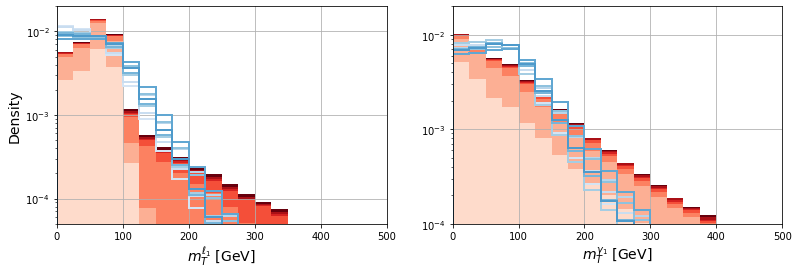

In [38]:
fig,ax = plt.subplots(1,2, figsize = (13,4))


# Mt lepton info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 20
bin_range = [0,500]

bkg_list = [mT_lepton_wjets[:wjets_sample], mT_lepton_wgamma[:wgamma_sample], mT_lepton_ttjets[:ttjets_sample],
            mT_lepton_zjets[:zjets_sample], 
            np.concatenate((mT_lepton_tj[:tj_sample], mT_lepton_tb[:tb_sample], mT_lepton_tw[:tw_sample])),
            mT_lepton_ttgamma[:ttgamma_sample],
            np.concatenate((mT_lepton_zz[:zz_sample], mT_lepton_wz[:wz_sample], mT_lepton_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)
#ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.35, 1.4), ncol = 4) 

for i in BPs2plot:
    ax[ncol].hist(mT_lepton_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,500)
ax[ncol].set_ylim(5e-5,2e-2)
ax[ncol].set_ylabel("Density",fontsize=14)

# Mt photon
ncol = 1
nbins = 20
bin_range = [0,500]

bkg_list = [mT_photon_wjets[:wjets_sample], mT_photon_wgamma[:wgamma_sample], mT_photon_ttjets[:ttjets_sample],
            mT_photon_zjets[:zjets_sample], 
            np.concatenate((mT_photon_tj[:tj_sample], mT_photon_tb[:tb_sample], mT_photon_tw[:tw_sample])),
            mT_photon_ttgamma[:ttgamma_sample],
            np.concatenate((mT_photon_zz[:zz_sample], mT_photon_wz[:wz_sample], mT_photon_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(mT_photon_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, label = 'BP'+ str(i+1))
#ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1., 1.4), ncol = 3)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_ylim(1e-4,2e-2)
ax[ncol].set_xlim(0,500)

plt.savefig('../graph/mt_lepton_mt_photon.pdf', bbox_inches='tight')

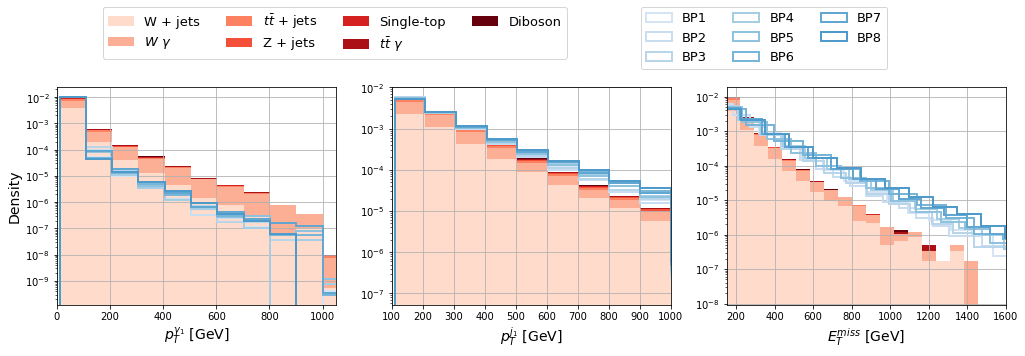

In [39]:
fig,ax = plt.subplots(1,3, figsize = (17,4))

# Pt Photon -----------------------------------------------------------------------------------------------------------------------
ncol  = 0
nbins = np.array([  10.,  109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])

bkg_list = [photon_wjets[:wjets_sample,0], photon_wgamma[:wgamma_sample,0], photon_ttjets[:ttjets_sample,0], 
            photon_zjets[:zjets_sample,0], 
            np.concatenate((photon_tj[:tj_sample,0], photon_tb[:tb_sample,0], photon_tw[:tw_sample,0])),
            photon_ttgamma[:ttgamma_sample,0], 
            np.concatenate((photon_zz[:zz_sample,0],photon_wz[:wz_sample,0],photon_ww[:ww_sample,0]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.85, 1.4), ncol = 4) 


for i in BPs2plot:
    ax[ncol].hist(photon_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,1050)
ax[ncol].set_ylabel("Density",fontsize=14)


# Pt jet -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = np.array([109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])

bkg_list = [jet_wjets[:wjets_sample,0], jet_wgamma[:wgamma_sample,0], jet_ttjets[:ttjets_sample,0], 
            jet_zjets[:zjets_sample,0], 
            np.concatenate((jet_tj[:tj_sample,0], jet_tb[:tb_sample,0], jet_tw[:tw_sample,0])),
            jet_ttgamma[:ttgamma_sample,0],
            np.concatenate((jet_zz[:zz_sample,0],jet_wz[:wz_sample,0],jet_ww[:ww_sample,0]))
           ]
ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(jet_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, label = 'BP'+ str(i+1))
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.8, 1.4), ncol = 3)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(100,1000)



# Pt MET -----------------------------------------------------------------------------------------------------------------------
ncol = 2
nbins = 20
bin_range = [150,1600]

bkg_list = [MET_wjets[:wjets_sample,0], MET_wgamma[:wgamma_sample,0], MET_ttjets[:ttjets_sample,0], 
            MET_zjets[:zjets_sample,0], 
            np.concatenate((MET_tj[:tj_sample,0], MET_tb[:tb_sample,0], MET_tw[:tw_sample,0])),
            MET_ttgamma[:ttgamma_sample,0],
            np.concatenate((MET_zz[:zz_sample,0],MET_wz[:wz_sample,0],MET_ww[:ww_sample,0]))
           ]
ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(MET_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)


ax[ncol].grid()
ax[ncol].set_xlabel(r"$E_{T}^{miss}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(150,1600)

plt.savefig('../graph/PT_photon_PT_jet_ETmiss.pdf', bbox_inches='tight')

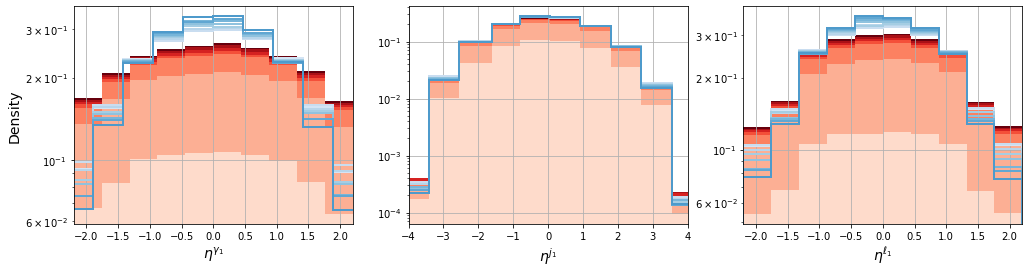

In [40]:
fig,ax = plt.subplots(1,3, figsize = (17,4))

# eta Photon -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 10
bin_range = [-2.2,2.2]

bkg_list = [photon_wjets[:wjets_sample,1], photon_wgamma[:wgamma_sample,1], photon_ttjets[:ttjets_sample,1],
            photon_zjets[:zjets_sample,1], 
            np.concatenate((photon_tj[:tj_sample,1], photon_tb[:tb_sample,1], photon_tw[:tw_sample,1])),
            photon_ttgamma[:ttgamma_sample,1],
            np.concatenate((photon_zz[:zz_sample,1],photon_wz[:wz_sample,1],photon_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(photon_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{\gamma_{1}}$",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-2.2,2.2)
ax[ncol].set_ylabel("Density",fontsize=14)


# eta jet -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = np.asarray([-8.3 , -3.42, -2.55, -1.62, -0.80, 0.063 , 0.93, 1.80, 2.68, 3.55, 8.42])

bkg_list = [jet_wjets[:wjets_sample,1], jet_wgamma[:wgamma_sample,1], jet_ttjets[:ttjets_sample,1],
            jet_zjets[:zjets_sample,1], 
            np.concatenate((jet_tj[:tj_sample,1], jet_tb[:tb_sample,1], jet_tw[:tw_sample,1])),
            jet_ttgamma[:ttgamma_sample,1], 
            np.concatenate((jet_zz[:zz_sample,1],jet_wz[:wz_sample,1],jet_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(jet_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{j_{1}}$",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-4.,4.)


# eta lepton -----------------------------------------------------------------------------------------------------------------------
ncol = 2
nbins = 10
bin_range = [-2.2,2.2]

bkg_list = [lepton_wjets[:wjets_sample,1], lepton_wgamma[:wgamma_sample,1], lepton_ttjets[:ttjets_sample,1],
            lepton_zjets[:zjets_sample,1], 
            np.concatenate((lepton_tj[:tj_sample,1], lepton_tb[:tb_sample,1], lepton_tw[:tw_sample,1])),
            lepton_ttgamma[:ttgamma_sample,1],
            np.concatenate((lepton_zz[:zz_sample,1],lepton_wz[:wz_sample,1],lepton_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(lepton_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{\ell_{1}}$",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-2.2,2.2)

plt.savefig('../graph/eta_photon_lepton_jet_dist.pdf', bbox_inches='tight')

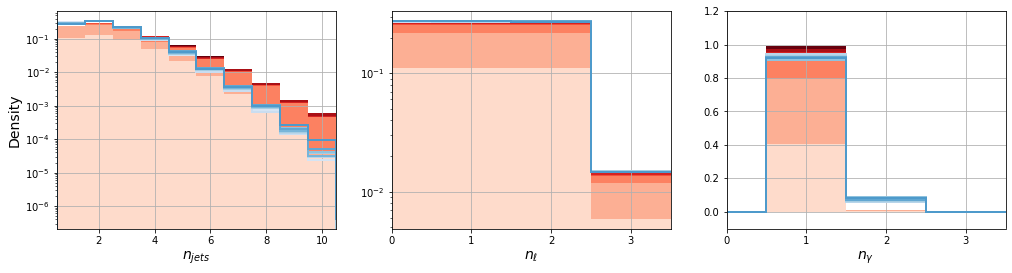

In [41]:
fig,ax = plt.subplots(1,3, figsize = (17,4))


# Num jets
ncol = 0
nbins = np.asarray([-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,25])

bkg_list = [hadinfo_wjets[:wjets_sample,2], hadinfo_wgamma[:wgamma_sample,2], hadinfo_ttjets[:ttjets_sample,2],
            hadinfo_zjets[:zjets_sample,2], 
            np.concatenate((hadinfo_tj[:tj_sample,2], hadinfo_tb[:tb_sample,2], hadinfo_tw[:tw_sample,2])),
            hadinfo_ttgamma[:ttgamma_sample,2],
            np.concatenate((hadinfo_zz[:zz_sample,2],hadinfo_wz[:wz_sample,2],hadinfo_ww[:ww_sample,2]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(hadinfo_NP[i][:,2], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{jets}$ ",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0.5,10.5)

ax[ncol].set_ylabel("Density",fontsize=14)

# Num leptons
ncol = 1
nbins = np.asarray([-0.5,0.5,1.5,2.5,14.5])

bkg_list = [lepton_wjets[:wjets_sample,2], lepton_wgamma[:wgamma_sample,2], lepton_ttjets[:ttjets_sample,2],
            lepton_zjets[:zjets_sample,2], 
            np.concatenate((lepton_tj[:tj_sample,2], lepton_tb[:tb_sample,2], lepton_tw[:tw_sample,2])),
            lepton_ttgamma[:ttgamma_sample,2],
            np.concatenate((lepton_zz[:zz_sample,2],lepton_wz[:wz_sample,2],lepton_ww[:ww_sample,2]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(lepton_NP[i][:,2], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{\ell}$ ",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0.5,3.5)
ax[ncol].set_xticks([0,1,2,3])


# Num photons
ncol = 2
bins = [0.5,1.5,2.5,3.5,4.5]

bkg_list = [photon_wjets[:wjets_sample,3], photon_wgamma[:wgamma_sample,3], photon_ttjets[:ttjets_sample,3],
            photon_zjets[:zjets_sample,3], 
            np.concatenate((photon_tj[:tj_sample,3], photon_tb[:tb_sample,3], photon_tw[:tw_sample,3])),
            photon_ttgamma[:ttgamma_sample,3],
            np.concatenate((photon_zz[:zz_sample,3],photon_wz[:wz_sample,3],photon_ww[:ww_sample,3]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(photon_NP[i][:,3], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{\gamma}$",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_xlim(0.5,3.5)
ax[ncol].set_ylim(-0.1,1.2)
ax[ncol].set_xticks([0,1,2,3])

plt.savefig('../graph/njets_nleptons_nphoton.pdf', bbox_inches='tight')

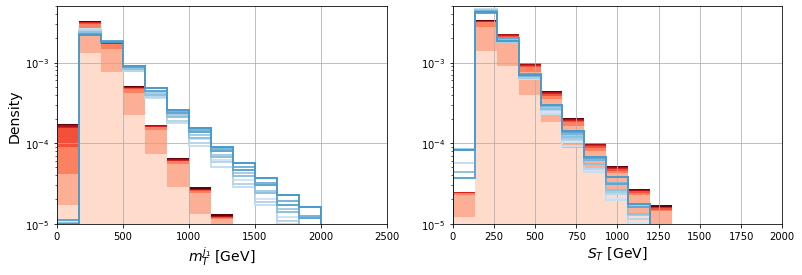

In [42]:
fig,ax = plt.subplots(1,2, figsize = (13,4))

# Mt jet info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 15
bin_range = [0,2500]

bkg_list = [mT_jet_wjets[:wjets_sample], mT_jet_wgamma[:wgamma_sample], mT_jet_ttjets[:ttjets_sample],
            mT_jet_zjets[:zjets_sample], 
            np.concatenate((mT_jet_tj[:tj_sample], mT_jet_tb[:tb_sample], mT_jet_tw[:tw_sample])),
            mT_jet_ttgamma[:ttgamma_sample],
            np.concatenate((mT_jet_zz[:zz_sample], mT_jet_wz[:wz_sample], mT_jet_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(mT_jet_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)
ax[ncol].set_ylabel("Density",fontsize=14)


# ST info
ncol = 1
nbins = 15
bin_range = [0,2000]

bkg_list = [ST_wjets[:wjets_sample], ST_wgamma[:wgamma_sample], ST_ttjets[:ttjets_sample],
            ST_zjets[:zjets_sample], 
            np.concatenate((ST_tj[:tj_sample], ST_tb[:tb_sample], ST_tw[:tw_sample])),
            ST_ttgamma[:ttgamma_sample],
            np.concatenate((ST_zz[:zz_sample], ST_wz[:wz_sample], ST_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(ST_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$S_{T}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2000)
ax[ncol].set_ylim(1e-5,5e-3)

plt.savefig('../graph/mt_jet_ST.pdf', bbox_inches='tight')

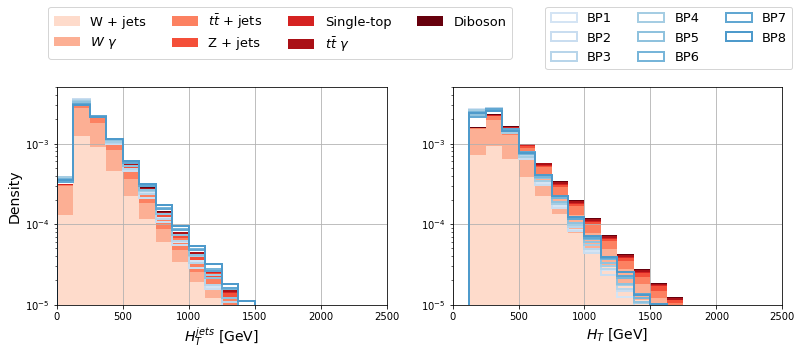

In [43]:
nbins = 20#np.asarray([121.16, 467.7, 814.2, 1160.8, 1507.3, 1853.9, 2200.4, 2546.9, 2893.5, 3240.0, 10000])

fig,ax = plt.subplots(1,2, figsize = (13,4))

# Ht info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
xlabels = [r"$H_{T}^{jets}$ [GeV]", r"$H_{T}^{jets}$ [GeV]"]
bin_range = [0,2500]
nbins = 20

bkg_list = [hadinfo_wjets[:wjets_sample,1], hadinfo_wgamma[:wgamma_sample,1], hadinfo_ttjets[:ttjets_sample,1],
            hadinfo_zjets[:zjets_sample,1], 
            np.concatenate((hadinfo_tj[:tj_sample,1], hadinfo_tb[:tb_sample,1], hadinfo_tw[:tw_sample,1])),
            hadinfo_ttgamma[:ttgamma_sample,1],
            np.concatenate((hadinfo_zz[:zz_sample,1],hadinfo_wz[:wz_sample,1],hadinfo_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.40, 1.4), ncol = 4) 

for i in BPs2plot:
    ax[ncol].hist(hadinfo_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$H_{T}^{jets}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("Density",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)

# HT
ncol = 1

bkg_list = [hadinfo_wjets[:wjets_sample,0], hadinfo_wgamma[:wgamma_sample,0], hadinfo_ttjets[:ttjets_sample,0],
            hadinfo_zjets[:zjets_sample,0], 
            np.concatenate((hadinfo_tj[:tj_sample,0], hadinfo_tb[:tb_sample,0], hadinfo_tw[:tw_sample,0])),
            hadinfo_ttgamma[:ttgamma_sample,0],
            np.concatenate((hadinfo_zz[:zz_sample,0],hadinfo_wz[:wz_sample,0],hadinfo_ww[:ww_sample,0]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(hadinfo_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range, label = 'BP'+ str(i+1))
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.05, 1.4), ncol = 3)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$H_{T}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)

plt.savefig('../graph/HT_info_dist.pdf', bbox_inches='tight')

## ML Analysis

In [45]:
Z_BL_loops          = list(np.load('../data/models/Z_BL_MET100_BPI.npy'))
Z_BL_std_loops      = list(np.load('../data/models/Z_BL_std_MET100_BPI.npy'))
muhat_BL_loops      = list(np.load('../data/models/muhat_BL_MET100_BPI.npy'))
Z_MLL_loops         = list(np.load('../data/models/Z_MLL_MET100_BPI.npy'))
Z_MLL_std_loops     = list(np.load('../data/models/Z_MLL_std_MET100_BPI.npy'))
muhat_MLL_loops     = list(np.load('../data/models/muhat_MLL_MET100_BPI.npy'))
Z_MLL_new_loops     = list(np.load('../data/models/Z_MLL_new_MET100_BPI.npy'))
Z_MLL_new_std_loops = list(np.load('../data/models/Z_MLL_new_std_MET100_BPI.npy'))
muhat_MLL_new_loops = list(np.load('../data/models/muhat_MLL_new_MET100_BPI.npy'))
Z_sbc_loops         = list(np.load('../data/models/Z_sbc_MET100_BPI.npy'))
Z_sbc_std_loops     = list(np.load('../data/models/Z_sbc_std_MET100_BPI.npy'))

In [177]:
Z_BL_loops

[array([8.08709257, 5.85904428, 2.75759107, 3.96549847, 2.30231154,
        2.77740304, 1.18847178, 1.70329335]),
 array([7.89572532, 5.72911983, 2.6340412 , 3.91395851, 2.17366664,
        2.99657252, 1.07638295, 1.92731201]),
 array([8.18918081, 6.23451198, 2.51193704, 4.188133  , 1.98217248,
        2.90302276, 0.84520004, 1.66858891]),
 array([8.23447076, 5.93145815, 2.6669164 , 4.0237104 , 2.16951145,
        2.8993747 , 1.35782676, 1.80868017])]

In [178]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

In [179]:
nobs = len(photon_SM)
#BPS_trained = np.asarray([0]) #np.arange(15)
BPS_trained = np.arange(8)
nobs_bp = round(nobs / len(BPS_trained))

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df = pd.DataFrame()

#np.random.seed(28890)

mask_list = []
for bp in BPS_trained:
    print(bp)
    BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = nobs_bp, replace = False)
    mask = np.ones(len(photon_NP[bp]), dtype=bool)
    mask[BP_indices] = False
    mask_list.append( mask )
    
    if bp == 0:
        
        df[lst[0]] = np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][BP_indices,0]])
        df[lst[1]] = np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][BP_indices,1]])
        df[lst[2]] = np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][BP_indices,2]])
        df[lst[3]] = np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][BP_indices,3]])

        df[lst[4]] = np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][BP_indices,0]])
        df[lst[5]] = np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][BP_indices,1]])
        df[lst[6]] = np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][BP_indices,2]])

        df[lst[7]] = np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][BP_indices,0]])
        df[lst[8]] = np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][BP_indices,1]])
        df[lst[9]] = np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][BP_indices,2]])
        df[lst[10]] = np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][BP_indices,3]])
        df[lst[11]] = np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][BP_indices,4]])

        df[lst[12]] = np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][BP_indices,0]])
        df[lst[13]] = np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][BP_indices,2]])

        df[lst[14]] = np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][BP_indices,0]])
        df[lst[15]] = np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][BP_indices,1]])
        df[lst[16]] = np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][BP_indices,2]])

        df[lst[17]] = np.concatenate([ST_SM[SM_indices], ST_NP[bp][BP_indices]])
        df[lst[18]] = np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][BP_indices]])

        df[lst[19]] = np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][BP_indices]])
        df[lst[20]] = np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][BP_indices]])
        df[lst[21]] = np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][BP_indices]])


        df['bkg_flag'] = np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][BP_indices]))) )

        df[lst[22]] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices]))])
        
        df['bp_flag'] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) ])
    else:
        df_aux = pd.DataFrame()
        
        df_aux[lst[0]] = photon_NP[bp][BP_indices,0] 
        df_aux[lst[1]] = photon_NP[bp][BP_indices,1] 
        df_aux[lst[2]] = photon_NP[bp][BP_indices,2] 
        df_aux[lst[3]] = photon_NP[bp][BP_indices,3] 

        df_aux[lst[4]] = jet_NP[bp][BP_indices,0] 
        df_aux[lst[5]] = jet_NP[bp][BP_indices,1] 
        df_aux[lst[6]] = jet_NP[bp][BP_indices,2] 

        df_aux[lst[7]] = lepton_NP[bp][BP_indices,0] 
        df_aux[lst[8]] = lepton_NP[bp][BP_indices,1] 
        df_aux[lst[9]] = lepton_NP[bp][BP_indices,2] 
        df_aux[lst[10]] = lepton_NP[bp][BP_indices,3] 
        df_aux[lst[11]] = lepton_NP[bp][BP_indices,4] 

        df_aux[lst[12]] = MET_NP[bp][BP_indices,0] 
        df_aux[lst[13]] = MET_NP[bp][BP_indices,2] 

        df_aux[lst[14]] = hadinfo_NP[bp][BP_indices,0] 
        df_aux[lst[15]] = hadinfo_NP[bp][BP_indices,1] 
        df_aux[lst[16]] = hadinfo_NP[bp][BP_indices,2] 

        df_aux[lst[17]] = ST_NP[bp][BP_indices] 
        df_aux[lst[18]] = MET_sig_NP[bp][BP_indices] 

        df_aux[lst[19]] = mT_photon_NP[bp][BP_indices] 
        df_aux[lst[20]] = mT_jet_NP[bp][BP_indices] 
        df_aux[lst[21]] = mT_lepton_NP[bp][BP_indices] 


        df_aux['bkg_flag'] = np.zeros(len(photon_NP[bp][BP_indices]))

        df_aux[lst[22]] = np.ones(len(photon_NP[bp][BP_indices]))
        df_aux['bp_flag'] = np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) 
        
        df = pd.concat((df, df_aux))
df_array = np.asarray(df)
df

0
1
2
3
4
5
6
7


,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1,bp_flag
0,71.83,-2.106,1.006,1.0,191.41,-1.370,1.297,51.02,-0.566,-0.910,...,239.78,2.0,314.26,11.430014,248.583952,407.959397,101.690779,1.0,0.0,0.0
1,35.89,0.240,-0.381,1.0,579.38,-1.943,3.093,57.74,-0.594,-0.520,...,1059.64,2.0,673.01,3.752375,54.347636,454.651291,57.857969,2.0,0.0,0.0
2,23.14,-0.829,-0.392,1.0,153.95,-1.277,2.778,25.00,-2.002,-1.371,...,268.88,3.0,202.09,7.972455,4.411973,295.246050,51.930255,1.0,0.0,0.0
3,19.33,-0.616,-0.690,1.0,496.60,-0.742,-2.557,280.69,-1.590,0.532,...,612.74,3.0,796.62,6.012859,67.650675,600.440796,1.580667,1.0,0.0,0.0
4,12.19,0.743,-1.866,1.0,130.36,0.564,-1.160,210.82,0.733,-1.853,...,368.00,3.0,353.37,5.978027,76.064874,274.176438,317.296510,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,18.24,1.469,-2.320,1.0,111.78,0.084,1.788,16.44,0.206,-1.923,...,252.48,3.0,146.46,9.787088,17.362389,258.084206,4.176215,0.0,1.0,8.0
24996,10.31,0.527,1.904,1.0,223.67,-1.131,-2.708,11.38,-0.962,-1.521,...,252.49,2.0,245.36,14.805795,69.924509,468.069777,85.527499,0.0,1.0,8.0
24997,18.36,0.654,1.770,1.0,124.64,-0.645,-0.474,11.63,0.233,-0.637,...,124.64,1.0,154.63,11.240020,51.959230,262.915397,79.456743,0.0,1.0,8.0
24998,12.28,1.689,1.271,1.0,124.59,1.780,2.270,16.54,1.799,-1.904,...,124.59,1.0,153.41,8.679239,61.690289,231.080109,45.757477,0.0,1.0,8.0


In [180]:
print('There are ' + str(len(np.where(df_array[:,24] == 0)[0])) + ' bkg events')
for i in np.arange(8):
    print('There are ' + str(len(np.where(df_array[:,24] == (i+1))[0])) + ' BP' + str(i+1) + ' events')

There are 200001 bkg events
There are 25000 BP1 events
There are 25000 BP2 events
There are 25000 BP3 events
There are 25000 BP4 events
There are 25000 BP5 events
There are 25000 BP6 events
There are 25000 BP7 events
There are 25000 BP8 events


In [181]:
SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

#BPS_analyzed = np.asarray([0])
BPS_analyzed = np.arange(8)

df_test = pd.DataFrame()

for bp in BPS_analyzed:
    if bp in BPS_trained:
        mask = mask_list[np.where(BPS_trained == bp)[0][0]]
        mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 75000
    else:
        BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = 15_000, replace = False)
        mask = np.zeros(len(photon_NP[bp]), dtype=bool)
        mask[BP_indices] = True
    print(bp)
    #mask = mask_list[bp]
    #mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 15000
    if bp == 0:
        
        df_test[lst[0]] = np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][mask,0]])
        df_test[lst[1]] = np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][mask,1]])
        df_test[lst[2]] = np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][mask,2]])
        df_test[lst[3]] = np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][mask,3]])

        df_test[lst[4]] = np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][mask,0]])
        df_test[lst[5]] = np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][mask,1]])
        df_test[lst[6]] = np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][mask,2]])

        df_test[lst[7]] = np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][mask,0]])
        df_test[lst[8]] = np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][mask,1]])
        df_test[lst[9]] = np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][mask,2]])
        df_test[lst[10]] = np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][mask,3]])
        df_test[lst[11]] = np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][mask,4]])

        df_test[lst[12]] = np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][mask,0]])
        df_test[lst[13]] = np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][mask,2]])

        df_test[lst[14]] = np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][mask,0]])
        df_test[lst[15]] = np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][mask,1]])
        df_test[lst[16]] = np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][mask,2]])

        df_test[lst[17]] = np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][mask]])
        df_test[lst[18]] = np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][mask]])

        df_test[lst[19]] = np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][mask]])
        df_test[lst[20]] = np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][mask]])
        df_test[lst[21]] = np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][mask]])


        df_test['bkg_flag_pool'] = np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][mask]))) )

        df_test[lst[22]] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask]))])
        
        df_test['bp_flag'] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask])) * (bp+1) ])
        
    else:
        df_aux = pd.DataFrame()
        
        df_aux[lst[0]] = photon_NP[bp][mask,0] 
        df_aux[lst[1]] = photon_NP[bp][mask,1] 
        df_aux[lst[2]] = photon_NP[bp][mask,2] 
        df_aux[lst[3]] = photon_NP[bp][mask,3] 

        df_aux[lst[4]] = jet_NP[bp][mask,0] 
        df_aux[lst[5]] = jet_NP[bp][mask,1] 
        df_aux[lst[6]] = jet_NP[bp][mask,2] 

        df_aux[lst[7]] = lepton_NP[bp][mask,0] 
        df_aux[lst[8]] = lepton_NP[bp][mask,1] 
        df_aux[lst[9]] = lepton_NP[bp][mask,2] 
        df_aux[lst[10]] = lepton_NP[bp][mask,3] 
        df_aux[lst[11]] = lepton_NP[bp][mask,4] 

        df_aux[lst[12]] = MET_NP[bp][mask,0] 
        df_aux[lst[13]] = MET_NP[bp][mask,2] 

        df_aux[lst[14]] = hadinfo_NP[bp][mask,0] 
        df_aux[lst[15]] = hadinfo_NP[bp][mask,1] 
        df_aux[lst[16]] = hadinfo_NP[bp][mask,2] 

        df_aux[lst[17]] = ST_NP[bp][mask] 
        df_aux[lst[18]] = MET_sig_NP[bp][mask] 

        df_aux[lst[19]] = mT_photon_NP[bp][mask] 
        df_aux[lst[20]] = mT_jet_NP[bp][mask] 
        df_aux[lst[21]] = mT_lepton_NP[bp][mask] 


        df_aux['bkg_flag_pool'] = np.zeros(len(photon_NP[bp][mask]))

        df_aux[lst[22]] = np.ones(len(photon_NP[bp][mask]))
        
        df_aux['bp_flag'] = np.ones(len(photon_NP[bp][mask])) * (bp+1)
        
        df_test = pd.concat((df_test, df_aux))
df_test_array = np.asarray(df_test)
df_test

0
1
2
3
4
5
6
7


,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1,bp_flag
0,137.87,2.290,0.606,1.0,107.23,1.531,-0.461,36.96,1.963,-2.973,...,250.90,3.0,282.06,7.187921,236.714056,251.727179,54.523953,1.0,0.0,0.0
1,395.37,-2.303,0.490,1.0,208.10,1.064,2.560,167.04,0.511,-1.993,...,208.10,1.0,770.51,6.672296,523.666472,279.217291,26.008047,1.0,0.0,0.0
2,29.11,2.162,-3.054,1.0,229.50,0.980,1.402,68.71,1.321,-1.590,...,293.50,3.0,327.32,9.209471,85.276690,408.745885,23.785848,2.0,0.0,0.0
3,18.49,-1.427,-2.712,1.0,338.38,0.790,0.731,26.41,-0.004,-2.054,...,472.55,3.0,383.28,6.048130,6.250137,429.832408,31.807587,1.0,0.0,0.0
4,31.05,-1.215,-0.888,1.0,122.67,0.936,2.889,35.09,0.451,0.101,...,273.10,3.0,188.81,9.768999,19.379028,291.914010,56.651486,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92773,18.98,2.010,2.765,1.0,174.93,1.063,-2.111,16.11,-0.250,-0.376,...,203.70,2.0,210.02,13.081098,99.082745,375.414791,68.478542,0.0,1.0,8.0
92774,41.13,1.082,-0.862,2.0,1716.19,0.534,2.901,18.38,1.263,0.317,...,1950.17,4.0,1775.70,33.878359,164.826867,3237.516941,84.376151,0.0,1.0,8.0
92775,23.25,1.019,-1.799,1.0,398.87,0.697,0.085,12.19,0.773,1.947,...,431.39,2.0,434.31,19.465202,117.948709,819.109983,84.319937,0.0,1.0,8.0
92776,17.07,2.072,-1.625,1.0,147.20,2.335,-2.438,12.70,1.826,1.746,...,183.52,2.0,176.97,7.805155,84.984021,256.723219,28.684529,0.0,1.0,8.0


In [182]:
print('There are ' + str(len(np.where(df_test_array[:,24] == 0)[0])) + ' bkg events')
for i in np.arange(8):
    print('There are ' + str(len(np.where(df_test_array[:,24] == (i+1))[0])) + ' BP' + str(i+1) + ' events')

There are 439041 bkg events
There are 90294 BP1 events
There are 91074 BP2 events
There are 91061 BP3 events
There are 90967 BP4 events
There are 93231 BP5 events
There are 93105 BP6 events
There are 92113 BP7 events
There are 92778 BP8 events


In [183]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
val_size   = nobs - train_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
val_indices   = random_indices[train_size:]

In [184]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [185]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [186]:
print('y:', df.columns[-2]) # Just to check

y: SM=0 - NP=1


In [187]:
x_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_train        = df_array[train_indices, -2]

x_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_test        = df_test_array[:, -2]

x_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_val        = df_array[val_indices, -2]

In [188]:
for i, ibkg in enumerate(bkg):
    ind_train = np.where(bkg_flag_train == (i + 1))[0]
    if(len(ind_train) < globals()[ibkg + '_expected']): 
        print('In training there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_train), globals()[ibkg + '_expected']))
        
    ind_test = np.where(bkg_flag_test == (i + 1))[0]
    if(len(ind_test) < globals()[ibkg + '_expected']): 
        print('In testing there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_test), globals()[ibkg + '_expected']))
        
    ind_val = np.where(bkg_flag_val == (i + 1))[0]
    if(len(ind_val) < globals()[ibkg + '_expected']): 
        print('In val there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_val), globals()[ibkg + '_expected']))

In [189]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(x_train)

x_train = x_scaler.transform(x_train)
x_test  = x_scaler.transform(x_test)
x_val   = x_scaler.transform(x_val)

In [190]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
fit = True
if fit:
    classifier.fit(x_train, y_train, 
                   eval_set = [(x_train, y_train), (x_val, y_val)],
                   verbose  =True)
    classifier.save_model(f'../data/models/BPI_MET100_{len(Z_BL_loops)}.json')
else:
    classifier.load_model(f'../data/models/BPI_MET100_{len(Z_BL_loops)}.json')


[0]	validation_0-logloss:0.64829	validation_1-logloss:0.64855
[1]	validation_0-logloss:0.61122	validation_1-logloss:0.61156
[2]	validation_0-logloss:0.58042	validation_1-logloss:0.58086
[3]	validation_0-logloss:0.55393	validation_1-logloss:0.55432
[4]	validation_0-logloss:0.53155	validation_1-logloss:0.53204
[5]	validation_0-logloss:0.51206	validation_1-logloss:0.51270
[6]	validation_0-logloss:0.49485	validation_1-logloss:0.49545
[7]	validation_0-logloss:0.48038	validation_1-logloss:0.48119
[8]	validation_0-logloss:0.46723	validation_1-logloss:0.46811
[9]	validation_0-logloss:0.45590	validation_1-logloss:0.45685
[10]	validation_0-logloss:0.44607	validation_1-logloss:0.44721
[11]	validation_0-logloss:0.43664	validation_1-logloss:0.43790
[12]	validation_0-logloss:0.42838	validation_1-logloss:0.42976
[13]	validation_0-logloss:0.42139	validation_1-logloss:0.42294
[14]	validation_0-logloss:0.41425	validation_1-logloss:0.41605
[15]	validation_0-logloss:0.40808	validation_1-logloss:0.41001
[1

In [191]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(x_test).T[1]

In [192]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total = np.zeros(nvals) 
fpr_total = np.zeros(nvals) 
tpr_bkg   = np.zeros((len(bkg), nvals))
fpr_bkg   = np.zeros((len(bkg), nvals))

for ith, th in tqdm(enumerate(np.linspace(0,1, nvals))):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))

    for i, ibkg in enumerate(bkg):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == (i + 1)) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == (i + 1)) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]
    
        tpr_bkg[i, ith] = len(tp) / (len(tp) + len(fn))
        fpr_bkg[i, ith] = len(fp) / (len(fp) + len(tn))

50it [00:03, 16.35it/s]


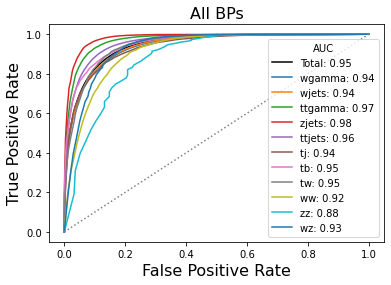

In [193]:
plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total: {:.2f}'.format(auc(fpr_total, tpr_total)))

for i, ibkg in enumerate(bkg):
    plt.plot(fpr_bkg[i,:], tpr_bkg[i,:], label = ibkg + ': {:.2f}'.format(auc(fpr_bkg[i,:], tpr_bkg[i,:])))
plt.legend(title = 'AUC')

plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"All BPs",fontsize=16)
plt.savefig(f'../graph/ROC_MET100_BPI_{len(Z_BL_loops)}.pdf', bbox_inches='tight')

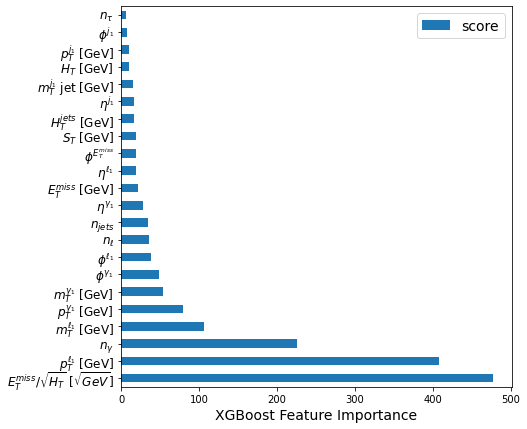

In [194]:
lst1 = ['$p_T^{\gamma_1}$ [GeV]', '$\eta^{\gamma_1}$', '$\phi^{\gamma_1}$', '$n_\gamma$',
       '$p_T^{j_1}$ [GeV]', '$\eta^{j_1}$', '$\phi^{j_1}$',
       '$p_T^{\ell_1}$ [GeV]', '$\eta^{\ell_1}$', '$\phi^{\ell_1}$', '$n_\ell$', '$n_{\\tau}$',
       '$E_T^{miss}$ [GeV]', '$\phi^{E_T^{miss}}$',
       '$H_T$ [GeV]', '$H_T^{jets}$ [GeV]', '$n_{jets}$',
       '$S_T$ [GeV]', 
       '$E_T^{miss}/\sqrt{H_T}$ [$\sqrt{GeV}$]',
       '$m_T^{\gamma_1}$ [GeV]', '$m_T^{j_{1}}$ jet [GeV]', '$m_T^{\ell_1}$ [GeV]',
       'SM=0 - NP=1']

fig, ax = plt.subplots(figsize = (7,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("XGBoost Feature Importance", fontsize = 14)
ax.set_yticklabels(np.asarray(lst1)[np.argsort(values)[::-1]], fontsize = 12)

ax.legend(fontsize = 14)

plt.savefig(f'../graph/ImpVars_MET100_BPI_{len(Z_BL_loops)}.pdf', bbox_inches='tight')

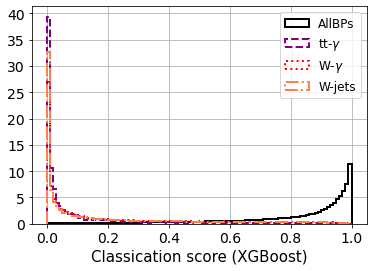

In [195]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'AllBPs', lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig(f'../graph/MLOutput_dist_MET100_BPI_{len(Z_BL_loops)}.pdf', bbox_inches="tight")

In [196]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [197]:
len(np.where(bkg_flag_test != 0)[0])

439041

In [198]:
len(np.where(bkg_flag_test == 0)[0])

734623

## Sequential selection criteria

In [199]:
nbins = 10
indices_aux = np.arange(len(df_test_array))

n_np0 = []
for bp in np.arange(8):
    n_np0.append( len(np.where(df_test_array[:, 24] == (bp+1))[0]) )
    
n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[:, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[:, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[:, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[:, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[:, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[:, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[:, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[:, 22] == 11)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 3), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    ZN_sup = np.zeros(nbins)
    ZN_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_sup, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_sup, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_sup, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_sup, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_sup, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_sup, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_sup, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_sup, 22] == 11)[0])
        
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
        
        S_expected_aux = np.zeros(8)
        for bp in np.arange(8):
            n_np = len(np.where( (df_test_array[indices_sup, 24] == (bp+1)) )[0])
            S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and ( np.min(S_expected_aux) > 5):
            Z_norm = np.zeros(8)
            for bp in np.arange(8):
                Z_norm[bp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp]))
                Z_norm[bp] = Z_norm[bp] / S_expected[bp]
            ZN_sup[icut] = np.mean(Z_norm)
            Z.append( ZN_sup[icut] )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_inf, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_inf, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_inf, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_inf, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_inf, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_inf, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_inf, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_inf, 22] == 11)[0])
        
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
        
        S_expected_aux = np.zeros(8)
        for bp in np.arange(8):
            n_np = len(np.where( (df_test_array[indices_inf, 24] == (bp+1)) )[0])
            S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (np.min(S_expected_aux) > 5):
            Z_norm = np.zeros(8)
            for bp in np.arange(8):
                Z_norm[bp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp]))
                Z_norm[bp] = Z_norm[bp] / S_expected[bp]
            ZN_inf[icut] = np.mean(Z_norm)
            Z.append( ZN_inf[icut] )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut     = np.argmax(np.asarray(Z))
    indices_aux = indices[max_cut]
    max_cut     = np.argmax((ZN_inf, ZN_sup))
    if max_cut >= len(ZN_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(ZN_sup)]) + '; <Z Norm> = ' + str(ZN_sup[max_cut - len(ZN_inf)]))
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(ZN_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(ZN_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; <Z Norm> = ' + str(ZN_inf[max_cut]))
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = np.zeros(8)
for bp in np.arange(8):
    n_np = len(np.where( (df_test_array[indices_inf, 24] == (bp+1)) )[0])
    S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))
    
# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux > 5) and (np.min(S_expected_aux) > 5): 
    for bp in np.arange(8):
        print('\n')
        print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp])))
        print('Expected Background = ' + str(B_expected_aux))
        print('Expected Signal = ' + str(S_expected_aux[bp]))

jet $p_T$ [GeV] <= 1436.8544444444444; <Z Norm> = 0.00258898911777919
$H_T$ [GeV] <= 1009.8044444444446; <Z Norm> = 0.002610210478369812
lepton $\phi$ <= 3.142; <Z Norm> = 0.002610210478369812
$m_T$ jet [GeV] >= 213.77969670267055; <Z Norm> = 0.0026959008967563968
jet $\phi$ <= 3.142; <Z Norm> = 0.0026959008967563968
photon $\phi$ <= 3.142; <Z Norm> = 0.0026959008967563968
MET $p_T$ [GeV] >= 202.84777777777776; <Z Norm> = 0.003021556756933261
$S_T$ [GeV] <= 516.4888888888889; <Z Norm> = 0.003059933509441568
num lepton <= 1.3333333333333333; <Z Norm> = 0.003061531934962413
lepton $p_T$ [GeV] <= 45.992222222222225; <Z Norm> = 0.0038299678487217423
photon $p_T$ [GeV] <= 51.61888888888889; <Z Norm> = 0.004180150957740355
lepton $\eta$ <= 2.499; <Z Norm> = 0.004180150957740355
num photon <= 2.0; <Z Norm> = 0.004180477109739247
$m_T$ photon [GeV] <= 254.09280022532977; <Z Norm> = 0.004182435626262849
MET sig [GeV] >= 11.306728251648746; <Z Norm> = 0.004343728516928134
$m_T$ lepton [GeV] >= 1

In [200]:
write = True
if write:
    with open(f'../data/cuts/MET100_BPI_supCuts_{len(Z_BL_loops)}.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open(f'../data/cuts/MET100_BPI_infCuts_{len(Z_BL_loops)}.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open(f'../data/cuts/MET100_BPI_supCuts_{len(Z_BL_loops)}.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open(f'../data/cuts/MET100_BPI_infCuts_{len(Z_BL_loops)}.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

100%|███████████████████████████████| 2000/2000 [00:33<00:00, 59.30it/s]

Final results: for BP 1
 
Z = 2.286451710210855; Z_std = 0.5501187395046611
B_exp = 61.2635; B_exp_std = 6.574273172754537
S_exp = 18.887; S_exp_std = 4.3848866576001715


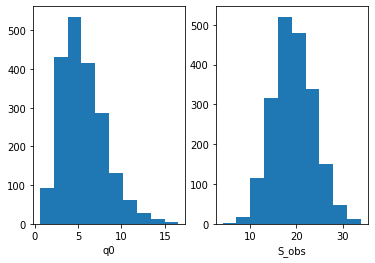

100%|███████████████████████████████| 2000/2000 [00:33<00:00, 59.63it/s]


Final results: for BP 2
 
Z = 1.858119431527399; Z_std = 0.5163478623943781
B_exp = 61.178; B_exp_std = 6.278639661582754
S_exp = 15.2575; S_exp_std = 4.012504672894475


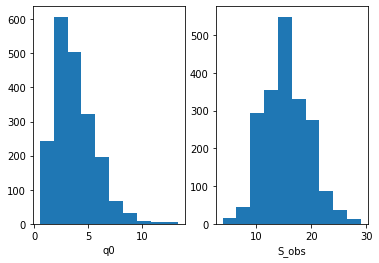

100%|███████████████████████████████| 2000/2000 [00:33<00:00, 59.86it/s]


Final results: for BP 3
 
Z = 1.4897967104144316; Z_std = 0.43302537343525677
B_exp = 61.4865; B_exp_std = 6.328966562559799
S_exp = 12.0825; S_exp_std = 3.4273450001422385


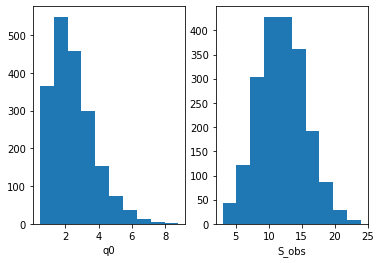

100%|███████████████████████████████| 2000/2000 [00:33<00:00, 59.83it/s]


Final results: for BP 4
 
Z = 1.719271170760476; Z_std = 0.46503076596737963
B_exp = 61.4895; B_exp_std = 6.420583287365721
S_exp = 14.023; S_exp_std = 3.65547137863231


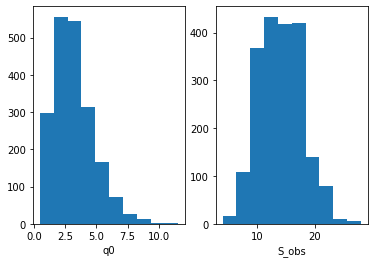

100%|███████████████████████████████| 2000/2000 [00:33<00:00, 59.78it/s]

Final results: for BP 5
 
Z = 1.237216125159087; Z_std = 0.3885838816024365
B_exp = 61.2755; B_exp_std = 6.285666213696047
S_exp = 9.6515; S_exp_std = 3.1521497029804912


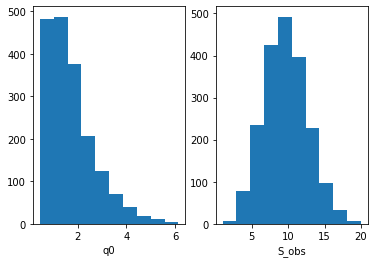

100%|███████████████████████████████| 2000/2000 [00:33<00:00, 59.77it/s]


Final results: for BP 6
 
Z = 1.3455269010667734; Z_std = 0.41337004446688735
B_exp = 61.3065; B_exp_std = 6.317005441663005
S_exp = 10.7635; S_exp_std = 3.2690316226674834


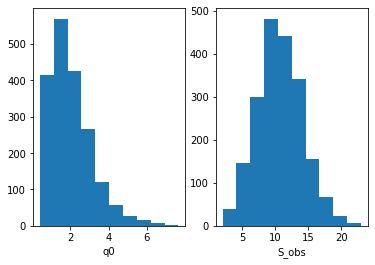

100%|███████████████████████████████| 2000/2000 [00:34<00:00, 58.77it/s]


Final results: for BP 7
 
Z = 0.9168764871586149; Z_std = 0.2674156764602814
B_exp = 61.3385; B_exp_std = 6.33244958527109
S_exp = 5.984; S_exp_std = 2.4838969382806524


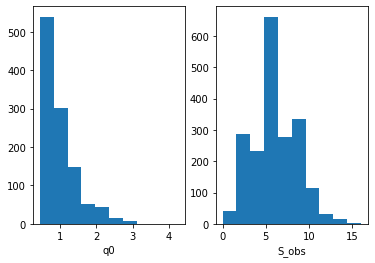

100%|███████████████████████████████| 2000/2000 [00:34<00:00, 58.71it/s]


Final results: for BP 8
 
Z = 1.0030475454856749; Z_std = 0.3221883736437571
B_exp = 61.492; B_exp_std = 6.34105164779471
S_exp = 7.3; S_exp_std = 2.698147512646408


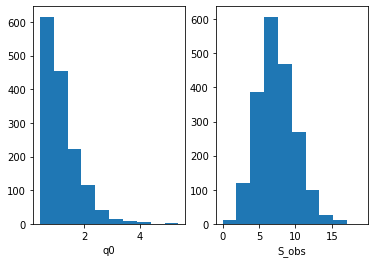

In [201]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,22] > 0)[0]

Z_sbc_std_BPs = np.ones(8) * (-99)
Z_sbc_BPs = np.ones(8) * (-99)
for bp in np.arange(8):
    
    NP_test_pool = np.where(df_test_array[:,24] == (bp+1))[0]

    q0_exp = np.zeros(nexperiments)
    B_observed_exp = np.zeros(nexperiments)
    S_observed_exp = np.zeros(nexperiments)
    for nexp in tqdm(range(nexperiments)):
        # Let's create a pseudo-experiment
        SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
        NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
        indices_aux = np.concatenate((NP_indices, SM_indices))

        # Let's make the cuts

        variables = list(sup_cuts.keys())
        for i in range(len(variables)):
            ind_var = np.where(df_test.columns == variables[i])[0][0]
            indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                    (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                                   )[0]]
        # Let's calculate everything

        n_np = len(np.where(df_test_array[indices_aux, 24] == (bp+1))[0])

        n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

        S_observed_exp[nexp] = n_np

        # Formula discovery
        B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets + \
                               n_ttjets + n_zjets + n_wz + \
                               n_zz + n_ww + n_tj + \
                               n_tb + n_tw

        N_observed = n_np + n_ttgamma + n_wgamma + n_wjets+ \
                     n_ttjets + n_zjets + n_wz + \
                     n_zz + n_ww + n_tj + \
                     n_tb + n_tw
        
        if (B_observed_exp[nexp] >= 5) and (n_np > 5): 
            q0_exp[nexp] = -2 * N_observed * np.log(B_observed_exp[nexp] / N_observed) -2 * (N_observed - B_observed_exp[nexp])
        else:
            q0_exp[nexp] = -99
            
    q0_exp = q0_exp[np.where(q0_exp > 0)[0]]
    Z_sbc_BPs[bp] = np.sqrt(np.median(q0_exp))
    Z_sbc_std_BPs[bp] = np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))
    print('Final results: for BP ' + str(bp+1) + '\n ')
    print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
    print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
    print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))
    fig,ax = plt.subplots(1,2)
    
    ax[0].hist(q0_exp)
    ax[0].set_xlabel('q0')
    ax[1].hist(S_observed_exp)
    ax[1].set_xlabel('S_obs')
    plt.show()

In [125]:
imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]
print(imp_vars)

['MET sig [GeV]' 'lepton $p_T$ [GeV]' 'num photon' '$m_T$ lepton [GeV]']


In [140]:
name_imp_vars = np.asarray(lst1)[np.argsort(values)[::-1]][:4]
print(name_imp_vars)

['$p_T^{\\ell_1}$ [GeV]' '$E_T^{miss}/\\sqrt{H_T}$ [$\\sqrt{GeV}$]'
 '$n_\\gamma$' '$m_T^{\\ell_1}$ [GeV]']


In [144]:
np.argsort(values)[::-1][:4]

array([ 7, 18,  3, 21])

In [148]:
np.min( [np.min(SM[imp_vars[0]]),np.min(NP[imp_vars[0]])])

10.01

In [138]:
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('white'), cmap_name = 'NP_cmap')

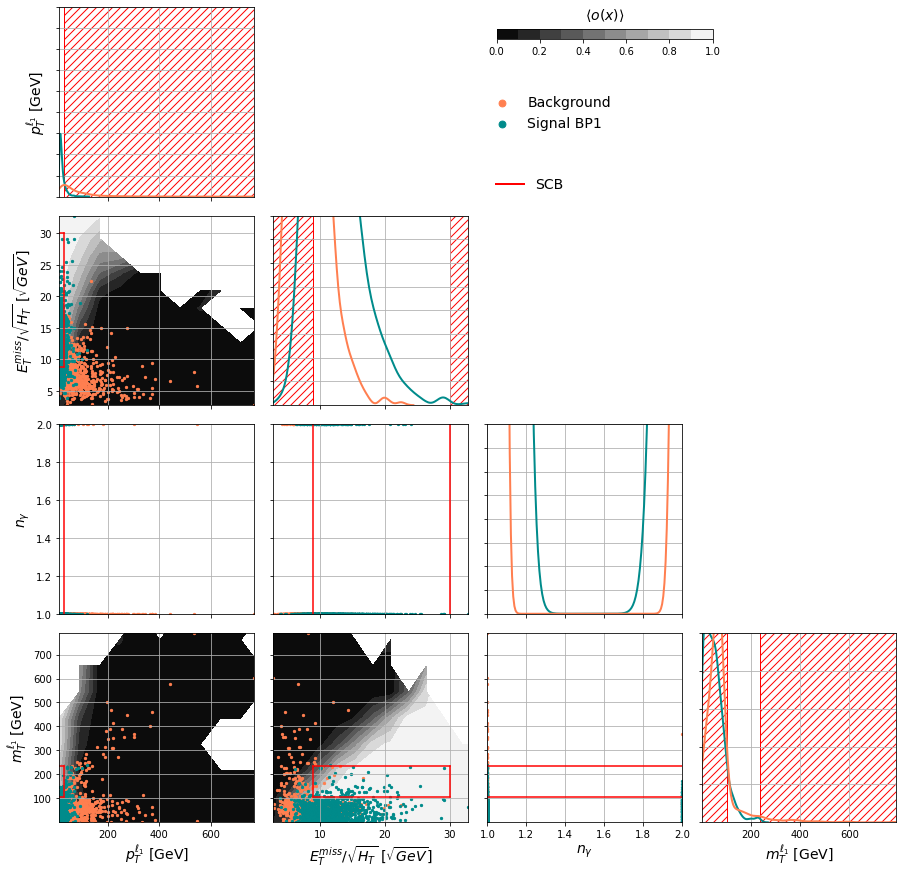

In [151]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bp_flag'] == 1]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  1000, replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]

rand_ind = np.random.choice(range(len(SM)), size =  1000, replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

#limites = [[4,35], [0,250], [0,5], [0,500]]
limites = [[np.min( [np.min(SM[imp_vars[0]]),np.min(NP[imp_vars[0]])]), np.max( [np.max(SM[imp_vars[0]]),np.max(NP[imp_vars[0]])])],
           [np.min( [np.min(SM[imp_vars[1]]),np.min(NP[imp_vars[1]])]), np.max( [np.max(SM[imp_vars[1]]),np.max(NP[imp_vars[1]])])],
           [np.min( [np.min(SM[imp_vars[2]]),np.min(NP[imp_vars[2]])]), np.max( [np.max(SM[imp_vars[2]]),np.max(NP[imp_vars[2]])])],
           [np.min( [np.min(SM[imp_vars[3]]),np.min(NP[imp_vars[3]])]), np.max( [np.max(SM[imp_vars[3]]),np.max(NP[imp_vars[3]])])]
            ]
ylimites = [[0,0.18], [0,0.04], [0,0.02], [0,0.01]]

rand_ind = np.random.choice(range(len(df_test)), size =  len(df_test), replace = False)
aux = df_test.iloc[rand_ind]
y_pred_aux = y_pred_xg[rand_ind]

with open(f'../data/cuts/MET100_BPI_supCuts_{len(Z_BL_loops)}.txt', "r") as fp:
    # Load the dictionary from the file
    sup_cuts = json.load(fp)
with open(f'../data/cuts/MET100_BPI_infCuts_{len(Z_BL_loops)}.txt', "r") as fp:
    # Load the dictionary from the file
    inf_cuts = json.load(fp)
        
fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = 'solid')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, facecolor = 'none', edgecolor = 'red', zorder = 0, hatch = '///')
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], facecolor = 'none', edgecolor = 'red', zorder = 0, hatch = '///')
                ax[i,j].set_ylim(ylimites[i])
            else:
                stats, xedge, yedge, _ = binned_statistic_2d(aux[imp_vars[j]], aux[imp_vars[i]], y_pred_aux, bins = 22)
                im_NP = ax[i,j].contourf(xedge[:-1], yedge[:-1], stats.T, cmap=NP_cmap, zorder = 0, levels = np.linspace(0,1,11))
                ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = 'coral', rasterized=True, label = 'Background')
                ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = 'darkcyan', rasterized=True, label = 'Signal BP1')
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')

                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(name_imp_vars[0], fontsize = 14)
ax[3,1].set_xlabel(name_imp_vars[1], fontsize = 14)
ax[3,2].set_xlabel(name_imp_vars[2], fontsize = 14)
ax[3,3].set_xlabel(name_imp_vars[3], fontsize = 14)

ax[0,0].set_ylabel(name_imp_vars[0], fontsize = 14)
ax[1,0].set_ylabel(name_imp_vars[1], fontsize = 14)
ax[2,0].set_ylabel(name_imp_vars[2], fontsize = 14)
ax[3,0].set_ylabel(name_imp_vars[3], fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])



# Legends------------------------------------------

ax[1,0].legend(loc = 'upper right', bbox_to_anchor=(2.9, 1.7), fontsize = 14, frameon = False, markerscale=3)

cax = fig.add_axes([0.53, 0.85, 0.2, 0.01])
cbar_NP = plt.colorbar(im_NP, cax=cax, orientation = 'horizontal')
cbar_NP.set_label(r'$\langle o(x) \rangle$', labelpad=-50, fontsize = 14)

patch1 = mlines.Line2D([], [], color='red', label='SCB', linestyle='-', markerfacecolor='none', markeredgewidth=2, lw = 2)
patch2 = mlines.Line2D([], [], color='red', label='BP 1', linestyle='-.', markerfacecolor='none', markeredgewidth=2, lw = 2)

# Add custom legend with boxes
ax[0,0].legend(handles=[patch1], loc = 'lower left', bbox_to_anchor=(2.18, -0.04), fontsize = 14, frameon = False )

plt.savefig(f'../graph/MET100_BPI_ImpVars_dist_{len(Z_BL_loops)}.pdf', bbox_inches='tight')

## Binned likelihood

In [202]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [203]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(439041,)
(734623,)


In [204]:
B_expected = int(B_expected)

B_expected:  147986

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


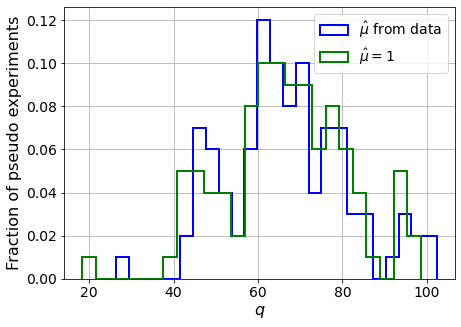

BP1

S_expected:  641.5741522357895
muhat mean:  1.0325
Z_bins:  8.140611966577872
std Z_bins:  0.8905613538636313
Z_bins mu=1:  8.146363436960087
std Z_bins mu=1:  0.8888167446728545

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


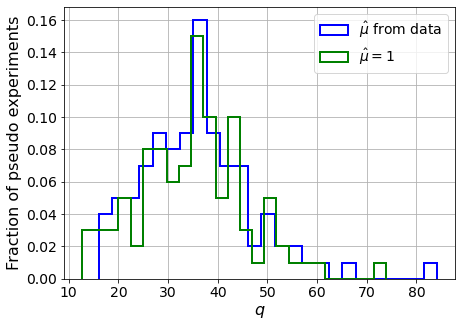

BP2

S_expected:  582.276369587
muhat mean:  1.0310000000000001
Z_bins:  6.002341791017957
std Z_bins:  0.9421347860721269
Z_bins mu=1:  6.002222601416881
std Z_bins mu=1:  0.9056857558316284

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


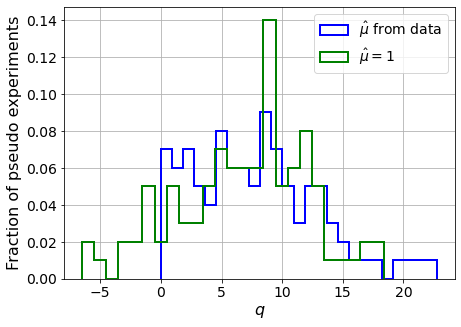

BP3

S_expected:  278.89596440145
muhat mean:  1.0015000000000003
Z_bins:  2.789952290498723
std Z_bins:  0.917054038823261
Z_bins mu=1:  2.788578686780211
std Z_bins mu=1:  0.9671228381386894

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


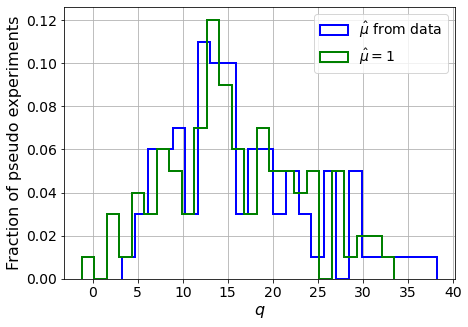

BP4

S_expected:  295.9616317164375
muhat mean:  1.0219999999999998
Z_bins:  3.883851986462055
std Z_bins:  0.980292756044248
Z_bins mu=1:  3.883851986462055
std Z_bins mu=1:  0.9559052540379082

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


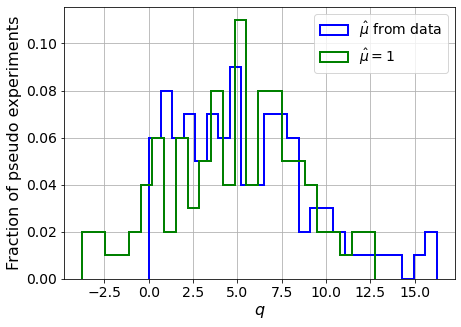

BP5

S_expected:  177.36868635267194
muhat mean:  1.044
Z_bins:  2.2677567160610446
std Z_bins:  0.8286783184739323
Z_bins mu=1:  2.2662910018240128
std Z_bins mu=1:  0.8180264805851896

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


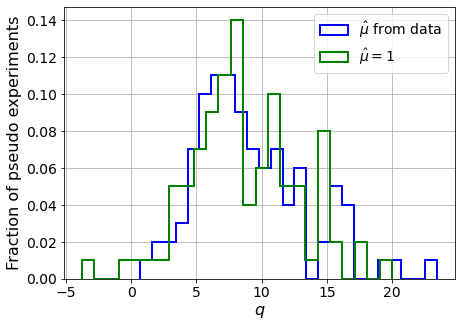

BP6

S_expected:  192.94194642254212
muhat mean:  1.0245
Z_bins:  2.875254030967127
std Z_bins:  0.7308977687288982
Z_bins mu=1:  2.875254030967127
std Z_bins mu=1:  0.7179011063393161

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


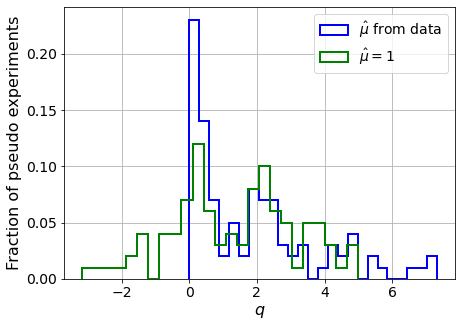

BP7

S_expected:  92.75013942173914
muhat mean:  1.0095
Z_bins:  1.1812421920837217
std Z_bins:  0.7905412817192036
Z_bins mu=1:  1.1814980923627991
std Z_bins mu=1:  0.7650244238215996

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


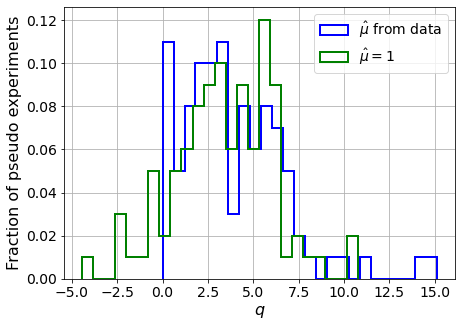

BP8

S_expected:  107.88296054380953
muhat mean:  1.0535
Z_bins:  1.8179970801026484
std Z_bins:  0.7823712638834175
Z_bins mu=1:  1.8182877260707828
std Z_bins mu=1:  0.7448877754799056

--------



In [205]:
D_or_E = 'discovery'
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]]
# requested number of pseudo experiments
num_pseudo = 100
    
print('B_expected: ', B_expected)
print('')
Z_BL_BPs = np.ones(8) * (-99)
Z_BL_std_BPs = np.ones(8) * (-99)
muhat_BL = np.ones(8) * (-99)
for bp in BPS_analyzed:
    Z_BL = BL_test_fast(D_or_E, pred_XG_SM, y_pred_xg[np.where( (df_test_array[:,24] == (bp+1)) )[0]], B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 
    
    Z_BL_BPs[bp] = Z_BL[0]
    Z_BL_std_BPs[bp] = Z_BL[1]
    muhat_BL[bp] = Z_BL[2]
    
    print('BP' + str(bp+1) + '\n')
    print('S_expected: ', S_expected[bp])
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=1: ', Z_BL[3])
    print('std Z_bins mu=1: ', Z_BL[4])
    print('')
    print('--------\n')

## KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [           -inf            -inf            -inf            -inf
            -inf            -inf  1.18796841e+04  1.14885432e+04
  1.10002555e+04  1.04112749e+04  9.71797899e+03  8.90529193e+03
  7.94072330e+03  6.79243935e+03  5.45847104e+03  3.90960854e+03
  2.09402791e+03  1.58301780e+00 -2.36615051e+03 -5.18537140e+03]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           

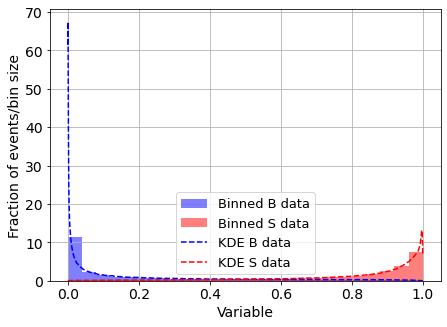

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503


In [206]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] > 0)[0]]

kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        50000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

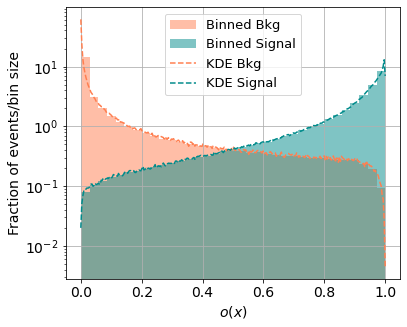

In [207]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,300)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='coral',alpha=0.5, linewidth=2, label=r'Binned Bkg');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='darkcyan',alpha=0.5, linewidth=2, label=r'Binned Signal');

plt.plot(s_vals, dens_bkg, color='coral',label=r'KDE Bkg',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='darkcyan',label=r'KDE Signal',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xlabel("$o(x)$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

plt.savefig('../graph/KDE_fit_ALLBPs.pdf', bbox_inches='tight')

In [208]:

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [209]:
pS_S_data

array([ 6.5458089 ,  3.86327803, 11.84320734, ...,  2.29559356,
        6.32899254, 15.11185098])

0:10000
3 done
4 done
0.004903216436279849
0.004903216436279849
B_expected:  147986
S_expected:  641

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


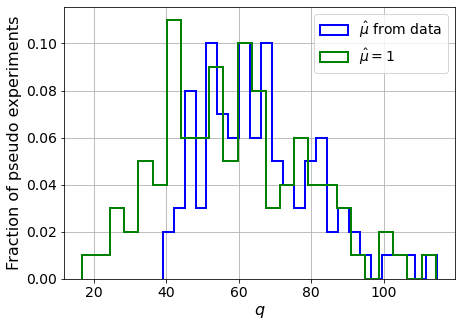

BP1
muhat mean:  0.7325000000000002
Z_MLL:  7.991589100846788
std Z_MLL:  0.9761193870951802
Z_MLL mu=1:  7.478519623662854
std Z_MLL mu=1:  1.3133692324259925
Z_MLL new:  5.826721354229857
std Z_MLL new:  1.073965104976961

--------

1:10000
3 done
4 done
0.004871637285155653
0.004871637285155653
B_expected:  147986
S_expected:  582

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


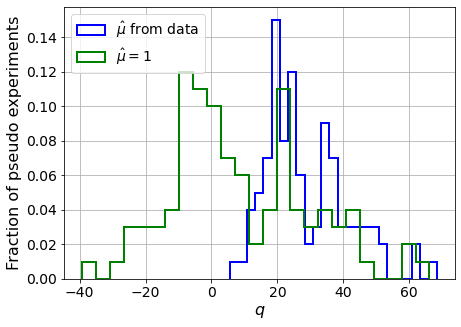

BP2
muhat mean:  0.5125000000000001
Z_MLL:  4.961235911289191
std Z_MLL:  1.267173577233883
Z_MLL mu=1:  1.9936082447728376
std Z_MLL mu=1:  5.224460188095329
Z_MLL new:  3.0311616076106924
std Z_MLL new:  1.3864396122017704

--------

2:10000
3 done
4 done
0.004839887394697737
0.004839887394697737
B_expected:  147986
S_expected:  278

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


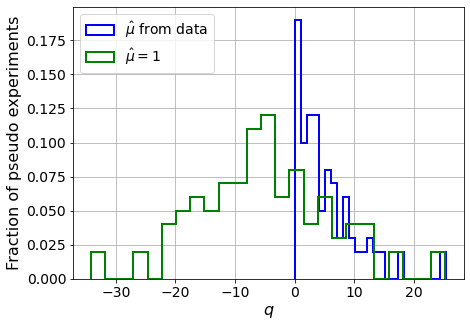

BP3
muhat mean:  0.38300000000000006
Z_MLL:  1.9759774635660943
std Z_MLL:  1.3051150915015362
Z_MLL mu=1:  2.335955927400981
std Z_MLL mu=1:  2.405205090826414
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

3:10000


/tmp/ipykernel_2725785/2262581457.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.004838014436940687
0.004838014436940687
B_expected:  147986
S_expected:  295

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


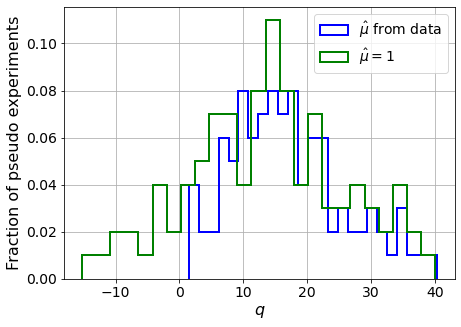

BP4
muhat mean:  0.7120000000000001
Z_MLL:  3.9623699129551735
std Z_MLL:  1.1167322190215676
Z_MLL mu=1:  3.7589727790537766
std Z_MLL mu=1:  1.5857915107147313
Z_MLL new:  2.326006833995836
std Z_MLL new:  1.2092760782908427

--------

4:10000
3 done
4 done
0.004890233934179157
0.004890233934179157
B_expected:  147986
S_expected:  177

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


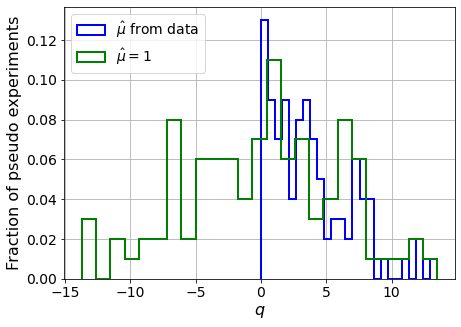

BP5
muhat mean:  0.4935
Z_MLL:  1.8033655723497162
std Z_MLL:  0.8457293949192667
Z_MLL mu=1:  0.7651972286179447
std Z_MLL mu=1:  3.8706440868696204
Z_MLL new:  0.2141758507351298
std Z_MLL new:  3.0388094935238774

--------

5:10000
3 done
4 done
0.004765772330233239
0.004765772330233239
B_expected:  147986
S_expected:  192

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


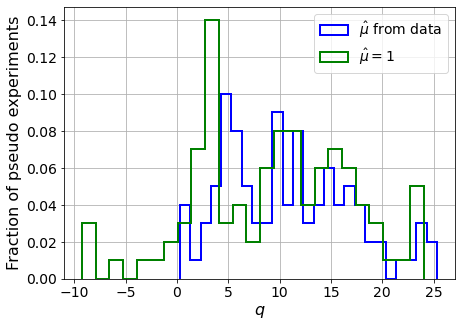

BP6
muhat mean:  0.8125000000000001
Z_MLL:  3.2059421179174477
std Z_MLL:  0.9518907573837609
Z_MLL mu=1:  3.1583873380884175
std Z_MLL mu=1:  1.1892735080837045
Z_MLL new:  1.934864720728451
std Z_MLL new:  0.9677617509373478

--------

6:10000
3 done
4 done
0.004558222798909139
0.004558222798909139
B_expected:  147986
S_expected:  92

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


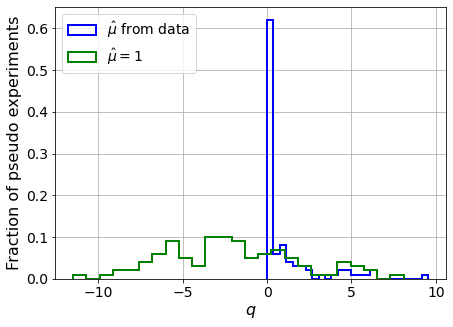

BP7
muhat mean:  0.29950000000000004
Z_MLL:  0.31935407844897046
std Z_MLL:  2.82355385221202
Z_MLL mu=1:  1.528154276533519
std Z_MLL mu=1:  1.2894145198326241
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

7:10000


/tmp/ipykernel_2725785/2262581457.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.004624504626615469
0.004624504626615469
B_expected:  147986
S_expected:  107

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


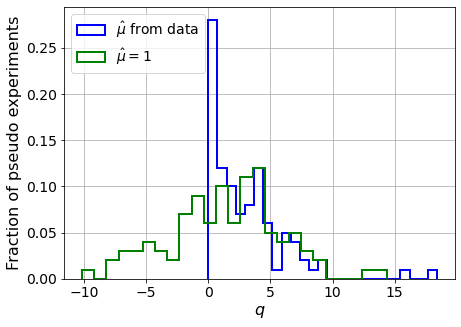

BP8
muhat mean:  0.6460000000000001
Z_MLL:  1.5095976173231607
std Z_MLL:  1.0491298669753637
Z_MLL mu=1:  1.2551708663626548
std Z_MLL mu=1:  1.8077321835350264
Z_MLL new:  0.4413407641182713
std Z_MLL new:  1.7993033714739533

--------



In [210]:
D_or_E = "discovery"

Z_MLL_BPs = np.ones(8) * (-99)
Z_MLL_std_BPs = np.ones(8) * (-99)
Z_MLL_BPs_new = np.ones(8) * (-99)
Z_MLL_std_BPs_new = np.ones(8) * (-99)
muhat_MLL = np.ones(8) * (-99)
muhat_MLL_new = np.ones(8) * (-99)

BPS_analyzed = [0,1,2,3,4,5,6,7]
for bp in BPS_analyzed:
    pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
    BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
    pred_XG_NP = pred_XG_NP[BP_indices]

    print(str(bp) + ':' + str(len(pred_XG_NP)))
    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    print(np.min(pB_S_data))
    pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
    pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
    print(np.min(pB_S_data))

    print('B_expected: ', int(B_expected))
    print('S_expected: ', int(S_expected[bp]))
    print('')

    Z_MLL = MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = 100, pred_XG_SM = pred_XG_SM, pred_XG_NP = pred_XG_NP)
    #Z_MLL = MLL_test_fsolve(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo, path = '../graph/BP' + str(bp+1) + '/')

    Z_MLL_BPs[bp] = Z_MLL[0]
    Z_MLL_std_BPs[bp] = Z_MLL[1]
    muhat_MLL[bp] = Z_MLL[2]
    
    Z_MLL_BPs_new[bp] = abs( np.median(Z_MLL[6]) )**0.5
    Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])
    
    muhat_MLL_new[bp] = np.mean(Z_MLL[5])
    print('BP' + str(bp+1))
    print('muhat mean: ', Z_MLL[2])
    print('Z_MLL: ', Z_MLL[0])
    print('std Z_MLL: ', Z_MLL[1])
    print('Z_MLL mu=1: ', Z_MLL[3])
    print('std Z_MLL mu=1: ', Z_MLL[4])
    print('Z_MLL new: ', Z_MLL_BPs_new[bp])
    print('std Z_MLL new: ', Z_MLL_std_BPs_new[bp])
    print('')
    print('--------\n')

In [211]:
Z_BL_loops.append( Z_BL_BPs )
Z_BL_std_loops.append( Z_BL_std_BPs )
muhat_BL_loops.append( muhat_BL )

Z_MLL_loops.append( Z_MLL_BPs )
Z_MLL_std_loops.append( Z_MLL_std_BPs )
muhat_MLL_loops.append( muhat_MLL )

Z_MLL_new_loops.append( Z_MLL_BPs_new )
Z_MLL_new_std_loops.append( Z_MLL_std_BPs_new )
muhat_MLL_new_loops.append( muhat_MLL_new )

Z_sbc_loops.append( Z_sbc_BPs )
Z_sbc_std_loops.append( Z_sbc_std_BPs )

In [175]:
Z_BL_loops_ar = np.asarray(Z_BL_loops)
Z_BL_std_loops_ar = np.asarray(Z_BL_std_loops)
muhat_BL_loops_ar = np.asarray(muhat_BL_loops)

Z_MLL_loops_ar = np.asarray(Z_MLL_loops)
Z_MLL_std_loops_ar = np.asarray(Z_MLL_std_loops)
muhat_MLL_loops_ar = np.asarray(muhat_MLL_loops)

Z_MLL_new_loops_ar = np.asarray(Z_MLL_new_loops)
Z_MLL_new_std_loops_ar = np.asarray(Z_MLL_new_std_loops)
muhat_MLL_new_loops_ar = np.asarray(muhat_MLL_new_loops)

Z_sbc_loops_ar = np.asarray(Z_sbc_loops)
Z_sbc_std_loops_ar = np.asarray(Z_sbc_std_loops)

In [176]:
np.save('../data/models/Z_BL_MET100_BPI.npy', Z_BL_loops_ar)
np.save('../data/models/Z_BL_std_MET100_BPI.npy', Z_BL_std_loops_ar)
np.save('../data/models/muhat_BL_MET100_BPI.npy', muhat_BL_loops_ar)
np.save('../data/models/Z_MLL_MET100_BPI.npy', Z_MLL_loops_ar)
np.save('../data/models/Z_MLL_std_MET100_BPI.npy', Z_MLL_std_loops_ar)
np.save('../data/models/muhat_MLL_MET100_BPI.npy', muhat_MLL_loops_ar)
np.save('../data/models/Z_MLL_new_MET100_BPI.npy', Z_MLL_new_loops_ar)
np.save('../data/models/Z_MLL_new_std_MET100_BPI.npy', Z_MLL_new_std_loops_ar)
np.save('../data/models/muhat_MLL_new_MET100_BPI.npy', muhat_MLL_new_loops_ar)
np.save('../data/models/Z_sbc_MET100_BPI.npy', Z_sbc_loops_ar)
np.save('../data/models/Z_sbc_std_MET100_BPI.npy', Z_sbc_std_loops_ar)

### Let's try

In [84]:

q_muhat_MLL_mu = []
q_muhat_MLL = []
muhat_selected_MLL_list = []
mu_list = []
q_list = []


B_rand = np.random.poisson(int(B_expected))

ran_ind = np.random.choice(indices_B, B_rand)
pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

pB_B_data_shuf = []
pS_B_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_B_data_shuf.append(pB_B_data[i])
    pS_B_data_shuf.append(pS_B_data[i])

pB_B_data_shuf  = np.array(pB_B_data_shuf)
pS_B_data_shuf  = np.array(pS_B_data_shuf)
        
    
S_rand = np.random.poisson(int(S_expected[bp]))
                
ran_ind = np.random.choice(indices_S, S_rand)
pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

pB_S_data_shuf = []
pS_S_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_S_data_shuf.append(pB_S_data[i])
    pS_S_data_shuf.append(pS_S_data[i])

pB_S_data_shuf  = np.array(pB_S_data_shuf)
pS_S_data_shuf  = np.array(pS_S_data_shuf)                

# p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

# p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
if mu < 0: mu = 0
if mu > 2: mu = 2
mu_list.append(mu)
q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))

if np.min(prob_x_given_B) == 0:
    print('There are events with p(s)=0')
    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
    print(np.min(prob_x_given_B))

# NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

# approximation: mu_hat=1 (discovery)
q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected[bp]) + sum( [np.log( 1 + ( (1.*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


# ESTIMATE mu_hat for this particular ensemble (implicit equation)
B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

# reference points
sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


# we need (implicit eq. for mu_hat) = 1
# conditions considering the reference points
if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

    muhat_selected_MLL = 2.1

elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

    muhat_selected_MLL = -0.1

elif sum_muhat_zero < 1 < sum_muhat_two:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 > 1:
            muhat_selected_MLL = muhat_test[vv]
            break

elif sum_muhat_two < 1 < sum_muhat_zero:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 < 1:
            muhat_selected_MLL = muhat_test[vv]
            break

muhat_selected_MLL_list.append(muhat_selected_MLL)

# compute the test statistic for each pseudo_exp considering mu_hat
if muhat_selected_MLL > 0:
    q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * S_expected[bp]) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

else:
    q_muhat_MLL.append( 0 )

There are events with p(s)=0
0.016781813945873785


In [85]:
print('mu:', muhat_selected_MLL)
print('q:', q_muhat_MLL)

mu: -0.1
q: [0]


In [86]:
bp = 3
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
pred_XG_NP = pred_XG_NP[BP_indices]

print(str(bp) + ':' + str(len(pred_XG_NP)))
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP

print(np.min(pB_S_data))
pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
print(np.min(pB_S_data))

print('B_expected: ', int(B_expected))
print('S_expected: ', int(S_expected[bp]))
print('')

3:10000
3 done
4 done
0.0
2.698293741968835e-05
B_expected:  147986
S_expected:  295



In [90]:
muhat_selected_MLL_list = []
q_muhat_MLL = []
q_muhat_MLL_mu = []
mu_list = []
q_list = []

# loop over the number of pseudo experiments

fail_pseudo = 0
for its in range(num_pseudo):

    # this pseudo-exp has B_rand number of B events
    B_rand = np.random.poisson(int(B_expected))

    ran_ind = np.random.choice(indices_B, B_rand)
    pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

    pB_B_data_shuf = []
    pS_B_data_shuf = []

    # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
    for i in ran_ind:
        pB_B_data_shuf.append(pB_B_data[i])
        pS_B_data_shuf.append(pS_B_data[i])

    pB_B_data_shuf  = np.array(pB_B_data_shuf)
    pS_B_data_shuf  = np.array(pS_B_data_shuf)

    # this pseudo-exp has S_rand number of S events
    S_rand = np.random.poisson(int(S_expected[bp]))

    ran_ind = np.random.choice(indices_S, S_rand)
    pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

    pB_S_data_shuf = []
    pS_S_data_shuf = []

    # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
    for i in ran_ind:
        pB_S_data_shuf.append(pB_S_data[i])
        pS_S_data_shuf.append(pS_S_data[i])

    pB_S_data_shuf  = np.array(pB_S_data_shuf)
    pS_S_data_shuf  = np.array(pS_S_data_shuf)                

    # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
    prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

    # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
    prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

    pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
    mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
    if mu < 0: mu = 0
    if mu > 2: mu = 2
    mu_list.append(mu)
    q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))

    if np.min(prob_x_given_B) == 0:
        print('There are events with p(s)=0')
        prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
        print(np.min(prob_x_given_B))

    # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

    # approximation: mu_hat=1 (discovery)
    q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected[bp]) + sum( [np.log( 1 + ( (1.*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



    # ESTIMATE mu_hat for this particular ensemble (implicit equation)
    B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

    # reference points
    sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


    # we need (implicit eq. for mu_hat) = 1
    # conditions considering the reference points
    if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

        muhat_selected_MLL = 2.1

    elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

        muhat_selected_MLL = -0.1

    elif sum_muhat_zero < 1 < sum_muhat_two:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 > 1:
                muhat_selected_MLL = muhat_test[vv]
                break

    elif sum_muhat_two < 1 < sum_muhat_zero:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 < 1:
                muhat_selected_MLL = muhat_test[vv]
                break


    # save the computed mu_hat (within range) for each pseudo_experiment
    if 'muhat_selected_MLL' not in locals():
        print('muhat2', sum_muhat_two)
        print('muhat0', sum_muhat_zero)
    muhat_selected_MLL_list.append(muhat_selected_MLL)


    # compute the test statistic for each pseudo_exp considering mu_hat
    if muhat_selected_MLL > 0:
        q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * S_expected[bp]) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

    else:
        q_muhat_MLL.append( 0 )

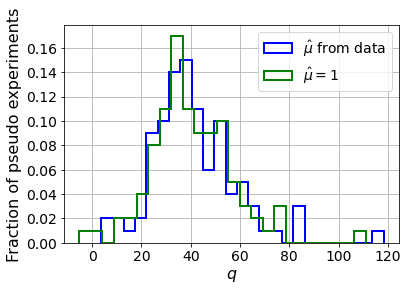

In [91]:
weights = np.ones_like(q_muhat_MLL)/float(len(q_muhat_MLL))
plt.hist(q_muhat_MLL, 25, weights=weights, histtype='step', color='blue', linewidth=2, label=r'$\hat{\mu}$ from data')

weights = np.ones_like(q_muhat_MLL_mu)/float(len(q_muhat_MLL_mu))
plt.hist(q_muhat_MLL_mu, 25, weights=weights, histtype='step', color='green', linewidth=2, label=r'$\hat{\mu}=1$')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q$",fontsize=16)
plt.ylabel("Fraction of pseudo experiments",fontsize=16)
plt.grid()
plt.legend(fontsize=14)

In [93]:
def MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected, num_pseudo, pred_XG_SM,pred_XG_NP):

	# FIND THE SIGNIFICANCE WITH MLL USING THE TEST STATISTIC FORMALISM (gives statistical error) 
	# Inputs:
		# D_or_E -> statistical test. Options: "exclusion" or "discovery"
		# pB_B_data -> array with BACKGROUND PDF evaluated in each BACKGROUND event,   p_B(background),   shape (len(background), )
		# pS_B_data -> array with SIGNAL PDF evaluated in each BACKGROUND event,       p_B(background),   shape (len(background), )
		# pB_S_data -> array with BACKGROUND PDF evaluated in each SIGNAL event,       p_B(background),   shape (len(signal), )
		# pS_S_data -> array with SIGNAL PDF evaluated in each SIGNAL event,           p_B(background),   shape (len(signal), )
		# B_expected -> number of Background events expected in a pseudo experiment
		# S_expected -> number of Signal events expected in a pseudo experiment
		# num_pseudo -> number of pseudo experiments that are used to compute the test statistic distribution
		
	# Outputs:
		# Z_bins -> value of the significance (using mu_hat that fits the data sample)
		# Z_bins_std -> statistical error (1 sigma) of the significance (using mu_hat that fits the data sample)
		# muhat_mean_bins -> mean of the mu_hat computed from the data sample
		# Z_bins_mu -> value of the significance (using a FIXED mu_hat=0 for exclusion, mu_hat=1 for discovery)
		# Z_bins_std_mu -> statistical error (1 sigma) of the significance (using a FIXED mu_hat=0 for exclusion, mu_hat=1 for discovery)
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]

    if D_or_E == 'discovery':
        indices_S = [i for i in range(len(pS_S_data))]
        
        
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    mu_list = []
    q_list = []
    
    # loop over the number of pseudo experiments
    
    fail_pseudo = 0
    for its in range(num_pseudo):
        
        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)
        pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)
        
        try:
            if D_or_E == 'exclusion': # only Background events
            
                # p_b(o(x_ensemble)) =  p_b(o(B_ensemble))
                prob_x_given_B = pB_B_data_shuf
    
                # p_s(o(x_ensemble)) =  p_s(o(B_ensemble))
                prob_x_given_S = pS_B_data_shuf
    
                if np.min(prob_x_given_B) == 0:
                    print('There are events with p(s)=0')
                    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
    
                # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment
    
                # approximation: mu_hat=0 (exclusion)
                q_muhat_MLL_mu.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                
                # ESTIMATE mu_hat for this particular ensemble (implicit equation)
                B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
                
                # reference points
                sum_muhat_zero = sum ( [(x*1.) / ( (x * (-0.25) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
                sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                
                # we need (implicit eq. for mu_hat) = 1
                # conditions considering the reference points
                if (sum_muhat_zero < sum_muhat_one < 1) or (1 < sum_muhat_one < sum_muhat_zero):
                    
                    muhat_selected_MLL = 1.1
                    
                elif (sum_muhat_one < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_one):
                    
                    muhat_selected_MLL = -0.3
    
                elif sum_muhat_zero < 1 < sum_muhat_one:
                    
                    # grid, mu_hat is around 0
                    muhat_test = np.arange(-0.25, 1., 0.05)
    
                    for vv in range(len(muhat_test)):
    
                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                        if mu_hat_condition_equal_1 > 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break
    
                elif sum_muhat_one < 1 < sum_muhat_zero:
                    
                    # grid, mu_hat is around 0
                    muhat_test = np.arange(-0.25, 1., 0.05)
    
                    for vv in range(len(muhat_test)):
    
                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                        if mu_hat_condition_equal_1 < 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break
                            
                            
                # save the computed mu_hat (within range) for each pseudo_experiment
                muhat_selected_MLL_list.append(muhat_selected_MLL)
                            
                            
                # compute the test statistic for each pseudo_exp considering mu_hat
                if muhat_selected_MLL > 1:
                    q_muhat_MLL.append( 0 )
    
                elif muhat_selected_MLL > 0:
                    q_muhat_MLL.append( 2 * ( ( (1.-muhat_selected_MLL) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_MLL*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                else:
                    q_muhat_MLL.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                
                
                
                
    
    
            if D_or_E == 'discovery': # Background and Signal events
                
                # this pseudo-exp has S_rand number of S events
                S_rand = np.random.poisson(int(S_expected))
                
                ran_ind = np.random.choice(indices_S, S_rand)
                pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]
    
                pB_S_data_shuf = []
                pS_S_data_shuf = []
    
                # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
                for i in ran_ind:
                    pB_S_data_shuf.append(pB_S_data[i])
                    pS_S_data_shuf.append(pS_S_data[i])
    
                pB_S_data_shuf  = np.array(pB_S_data_shuf)
                pS_S_data_shuf  = np.array(pS_S_data_shuf)                
                
                # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
                prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])
    
                # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
                prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])
    
                pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
                mu = find_mu(pb_ps_exp, S_expected, B_expected)
                if mu < 0: mu = 0
                if mu > 2: mu = 2
                mu_list.append(mu)
                q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected/B_expected) / (pb_ps_exp)))) - mu*S_expected))

                if np.min(prob_x_given_B) == 0:
                    print('There are events with p(s)=0')
                    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
                    print(np.min(prob_x_given_B))
    
                # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment
    
                # approximation: mu_hat=1 (discovery)
                q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                
                
                # ESTIMATE mu_hat for this particular ensemble (implicit equation)
                B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
                
                # reference points
                sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
                sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                
                # we need (implicit eq. for mu_hat) = 1
                # conditions considering the reference points
                if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
                    
                    muhat_selected_MLL = 2.1
                    
                elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
                    
                    muhat_selected_MLL = -0.1
    
                elif sum_muhat_zero < 1 < sum_muhat_two:
                    
                    # grid, mu_hat is around 1
                    muhat_test = np.arange(0, 2.05, 0.05)
    
                    for vv in range(len(muhat_test)):
    
                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                        if mu_hat_condition_equal_1 > 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break
    
                elif sum_muhat_two < 1 < sum_muhat_zero:
                    
                    # grid, mu_hat is around 1
                    muhat_test = np.arange(0, 2.05, 0.05)
    
                    for vv in range(len(muhat_test)):
    
                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                        if mu_hat_condition_equal_1 < 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break
                            
                            
                # save the computed mu_hat (within range) for each pseudo_experiment
                if 'muhat_selected_MLL' not in locals():
                    print('muhat2', sum_muhat_two)
                    print('muhat0', sum_muhat_zero)
                muhat_selected_MLL_list.append(muhat_selected_MLL)
                
                
                # compute the test statistic for each pseudo_exp considering mu_hat
                if muhat_selected_MLL > 0:
                    q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * S_expected) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                else:
                    q_muhat_MLL.append( 0 )
        except:
            fail_pseudo += 1
                
            
    print('Ratio of pseudo experiments that do not satisfied the MIN_EVS condition: ', fail_pseudo/num_pseudo)
    # Histogram of q_muhats
    plt.figure(figsize=(7,5))
    
    weights = np.ones_like(q_muhat_MLL)/float(len(q_muhat_MLL))
    plt.hist(q_muhat_MLL, 25, weights=weights, histtype='step', color='blue', linewidth=2, label=r'$\hat{\mu}$ from data')
    
    weights = np.ones_like(q_muhat_MLL_mu)/float(len(q_muhat_MLL_mu))
    if D_or_E == 'exclusion':
        plt.hist(q_muhat_MLL_mu, 25, weights=weights, histtype='step', color='green', linewidth=2, label=r'$\hat{\mu}=0$')
    if D_or_E == 'discovery':
        plt.hist(q_muhat_MLL_mu, 25, weights=weights, histtype='step', color='green', linewidth=2, label=r'$\hat{\mu}=1$')
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q$",fontsize=16)
    plt.ylabel("Fraction of pseudo experiments",fontsize=16)
    plt.grid()
    plt.legend(fontsize=14)
    plt.show()
    
    
    
    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)

    Z_MLL = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
    
    
    # With the approximation of mu_hat
    Z_MLL_mu = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_std_mu = np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu)
    
    
    return Z_MLL, Z_MLL_std, muhat_mean_MLL, Z_MLL_mu, Z_MLL_std_mu, mu_list, q_list





Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


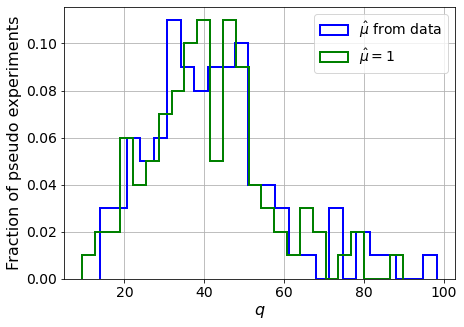

In [94]:
Z_MLL = MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = 100,pred_XG_SM=pred_XG_SM,pred_XG_NP=pred_XG_NP)

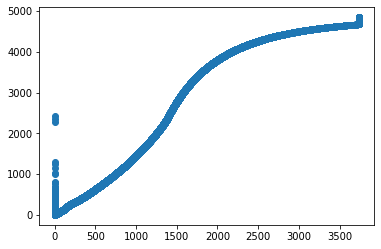

0.5580613340067002
0.10439617397580987
0.10439712693887603


In [81]:
indices_B = [i for i in range(len(pS_B_data))]

indices_S = [i for i in range(len(pS_S_data))]


muhat_selected_MLL_list = []
q_muhat_MLL = []
q_muhat_MLL_mu = []
mu_list = []
q_list = []


# this pseudo-exp has B_rand number of B events
B_rand = np.random.poisson(int(B_expected))

ran_ind = np.random.choice(indices_B, B_rand)
pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337 # To match previous method

pB_B_data_shuf = []
pS_B_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_B_data_shuf.append(pB_B_data[i])
    pS_B_data_shuf.append(pS_B_data[i])

pB_B_data_shuf  = np.array(pB_B_data_shuf)
pS_B_data_shuf  = np.array(pS_B_data_shuf)

# this pseudo-exp has S_rand number of S events
S_rand = np.random.poisson(int(S_expected[bp]))

ran_ind = np.random.choice(indices_S, S_rand)
pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

pB_S_data_shuf = []
pS_S_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_S_data_shuf.append(pB_S_data[i])
    pS_S_data_shuf.append(pS_S_data[i])

pB_S_data_shuf  = np.array(pB_S_data_shuf)
pS_S_data_shuf  = np.array(pS_S_data_shuf)


# p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

# p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

#%pb_ps_exp = prob_x_given_B / prob_x_given_S
pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])

plt.scatter(pb_ps_exp, prob_x_given_B / prob_x_given_S)
#plt.xscale('log')
#plt.yscale('log')
#%fig,ax = plt.subplots(1,2)
#%ax[0].scatter(pb_ps_B_data, pB_B_data_shuf / pS_B_data_shuf)
#%ax[0].set_xscale('log')
#%ax[0].set_yscale('log')
#%#ax[1].plot([0,400],[0,400])
#%ax[1].scatter(pb_ps_S_data, pB_S_data_shuf / pS_S_data_shuf)
#%#ax[1].plot([0,400],[0,400])
plt.show()

mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
print(mu)
print(find_mu(prob_x_given_B / prob_x_given_S, S_expected[bp], B_expected))
if mu < 0: mu = 0
if mu > 2: mu = 2
mu_list.append(mu)
q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))

if np.min(prob_x_given_B) == 0:
    print('There are events with p(s)=0')
    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
    print(np.min(prob_x_given_B))

# NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

# approximation: mu_hat=1 (discovery)
q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected[bp]) + sum( [np.log( 1 + ( (1.*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


# compute mu_hat from implicit equation
def f_mu_hat(mu_h, prob_x_given_B=prob_x_given_B, prob_x_given_S=prob_x_given_S):
    return sum ( [x / ( (x * mu_h * S_expected[bp]) + (y * B_expected) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) - 1


muhat_selected_MLL = fsolve(f_mu_hat,1, xtol=1e-2)[0]
print(muhat_selected_MLL)

Text(0, 0.5, 'KDE')

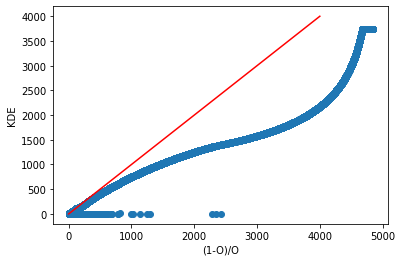

In [82]:
plt.scatter(prob_x_given_B / prob_x_given_S, pb_ps_exp)
#plt.xscale('log')
#plt.yscale('log')
plt.plot([1e-3,4e3],[1e-3,4e3],c = 'red')
plt.xlabel('(1-O)/O')
plt.ylabel('KDE')
#plt.savefig('../graph/comparison_KDE.pdf')

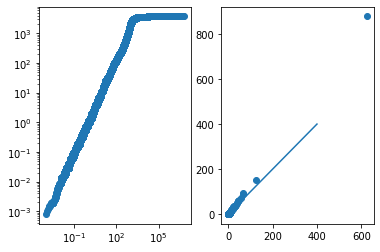

In [189]:
fig,ax = plt.subplots(1,2)

ax[0].scatter((1-pred_XG_SM)/pred_XG_SM, pB_B_data / pS_B_data)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].plot([0,400],[0,400])
ax[1].scatter((1-pred_XG_NP)/pred_XG_NP, pB_S_data / pS_S_data)
ax[1].plot([0,400],[0,400])

In [190]:
print(Z_MLL[0], Z_MLL[1])

5.3811970408441665 1.2407660614726699


In [191]:
print(abs( np.median(Z_MLL[8]) )**0.5)

2.693032119628668


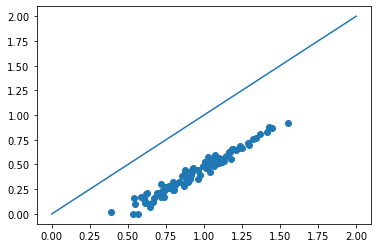

In [192]:
plt.scatter(Z_MLL[5], Z_MLL[7])
plt.plot([0,2],[0,2])

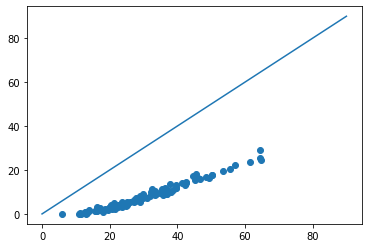

In [193]:
plt.scatter(Z_MLL[6], Z_MLL[8])
plt.plot([0,90],[0,90])

In [118]:
pb_ps_B_data = (1 - pred_XG_SM) / pred_XG_SM
pb_ps_S_data = (1 - pred_XG_NP) / pred_XG_NP

pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337

In [116]:
np.max(pB_B_data / pS_B_data)

3736.337703153999

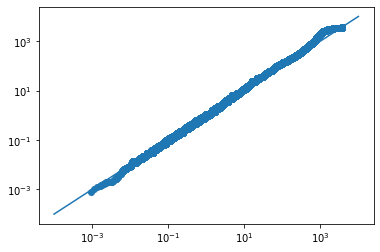

In [119]:
fig,ax = plt.subplots(1,1)

ax.scatter(pb_ps_B_data, pB_B_data / pS_B_data)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim(1e-4,1e4)
#ax.set_ylim(1e-4,1e4)
ax.plot([1e-4,1e4], [1e-4,1e4])



In [122]:
start = time.time()

D_or_E = "discovery"

indices_B = np.arange(len(pS_B_data))
indices_S = np.arange(len(pS_S_data))

Z_MLL_BPs_new = np.ones(8) * (-99)
Z_MLL_std_BPs_new = np.ones(8) * (-99)
BPS_analyzed = [0,1,2,3,4,5,6,7]

for bp in BPS_analyzed:
    pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
    BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
    pred_XG_NP = pred_XG_NP[BP_indices]

    print(str(bp) + ':' + str(len(pred_XG_NP)))
    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS
    mu_list = []
    q_list = []
    for its in range(100):
        B_rand = np.random.poisson(int(B_expected))
        ran_ind = np.random.choice(indices_B, B_rand)
        pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

        pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337 # To match previous method

        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)
        pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

        pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
        
        mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
        if mu < 0: mu = 0
        if mu > 2: mu = 2
        mu_list.append(mu)
        q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))


    
    Z_MLL_aux = abs( np.median(q_list) )**0.5
    Z_MLL_std_aux = np.std(q_list) / (2.*Z_MLL_aux)
    Z_MLL_BPs_new[bp] = Z_MLL_aux
    Z_MLL_std_BPs_new[bp] = Z_MLL_std_aux
    
    print('BP' + str(bp+1))
    print('muhat mean: ', np.mean(mu_list))
    print('Z_MLL: ', Z_MLL_aux)
    print('std Z_MLL: ', Z_MLL_std_aux)
    print('')
    print('--------\n')
    
stop = time.time()
print(f'Last {(stop-start)/60} minutes to perform the MLL')

0:10000
BP1
muhat mean:  0.5442385047467352
Z_MLL:  6.109123444572321
std Z_MLL:  1.2123884367551674

--------

1:10000
BP2
muhat mean:  0.3214808589536529
Z_MLL:  3.6939276760846163
std Z_MLL:  1.1017282297370747

--------

2:10000
BP3
muhat mean:  0.0974402414695244
Z_MLL:  0.18822815395286005
std Z_MLL:  4.5450778118234725

--------

3:10000
BP4
muhat mean:  0.3823396975331739
Z_MLL:  2.6417028317976627
std Z_MLL:  1.0201257683993008

--------

4:10000
BP5
muhat mean:  0.10804492916927216
Z_MLL:  0.06299995003594464
std Z_MLL:  10.900230841905575

--------

5:10000
BP6
muhat mean:  0.3645914169005714
Z_MLL:  1.617844385175915
std Z_MLL:  1.2889051380132766

--------

6:10000


/tmp/ipykernel_1817670/256691188.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_aux = np.std(q_list) / (2.*Z_MLL_aux)


BP7
muhat mean:  0.03924409566239821
Z_MLL:  0.0
std Z_MLL:  inf

--------

7:10000
BP8
muhat mean:  0.20397367896242258
Z_MLL:  0.1450419818870122
std Z_MLL:  5.654111573570895

--------

Last 0.07608150641123454 minutes to perform the MLL


(0.0, 20.0)

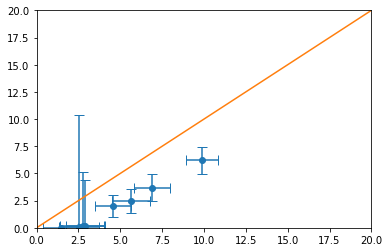

In [120]:
plt.errorbar(Z_MLL_BPs, Z_MLL_BPs_new, xerr=Z_MLL_std_BPs, yerr=Z_MLL_std_BPs_new, fmt='o', capsize=5)
plt.plot([0,20],[0,20])
plt.xlim(0,20)
plt.ylim(0,20)

In [112]:
print(np.min(pB_B_data))
pB_B_data[np.where(pB_B_data == 0 )[0]] = np.min(pB_B_data[np.where(pB_B_data > 0 )[0]])
pS_B_data[np.where(pS_B_data == 0 )[0]] = np.min(pS_B_data[np.where(pS_B_data > 0 )[0]])
print(np.min(pB_B_data))

0.012822047002307902
0.012822047002307902


In [154]:
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == 1)[0]]
BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
pred_XG_NP = pred_XG_NP[BP_indices]

In [155]:
pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP

print(np.min(pB_S_data))
pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
print(np.min(pB_S_data))

3 done
4 done
0.001973469036674877
0.001973469036674877


In [156]:
pb_ps_S_data = (1 - pred_XG_NP) / pred_XG_NP

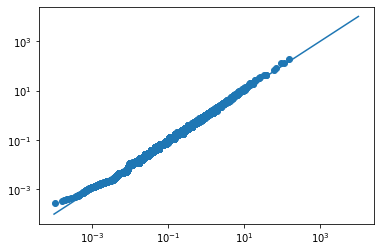

In [157]:
plt.scatter(pb_ps_S_data, pB_S_data / pS_S_data)
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-4,1e4)
#plt.ylim(1e-4,1e4)
plt.plot([1e-4,1e4], [1e-4,1e4])

In [132]:
indices_B = np.arange(len(pS_B_data))
indices_S = np.arange(len(pS_S_data))

In [147]:
S_expected = S_expected[0]

In [184]:
mu_list = []
q_muhat_new_list = []

q_muhat_MLL_mu_aprox_list = []

muhat_MLL_list = []
q_muhat_MLL_list = []
for its in tqdm(range(100)):
    # this pseudo-exp has B_rand number of B events
    B_rand = np.random.poisson(int(B_expected))

    ran_ind = np.random.choice(indices_B, B_rand)
    pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

    pB_B_data_shuf  = pB_B_data[ran_ind]
    pS_B_data_shuf  = pS_B_data[ran_ind]

    # this pseudo-exp has S_rand number of S events
    S_rand = np.random.poisson(int(S_expected))

    ran_ind = np.random.choice(indices_S, S_rand)
    pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

    pB_S_data_shuf  = pB_S_data[ran_ind]
    pS_S_data_shuf  = pS_S_data[ran_ind]

    # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
    prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

    # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
    prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

    pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
    if np.min(prob_x_given_B) == 0:
        print('There are events with p(s)=0')
        prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
        print(np.min(prob_x_given_B))

    # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment
    
    mu = find_mu(pb_ps_exp, S_expected, B_expected)
    mu_list.append(mu)
    #%print("Valor de mu:", mu)

    q_muhat_new =  2*(np.sum(np.log( 1 + ( (mu*S_expected/B_expected) / (pb_ps_exp)))) - mu*S_expected)
    #%print(q_muhat_new)
    q_muhat_new_list.append(q_muhat_new)
    
    # approximation: mu_hat=1 (discovery)
    q_muhat_MLL_mu_aprox = 2 * ( ( -1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) 
    q_muhat_MLL_mu_aprox_list.append(q_muhat_MLL_mu_aprox)
    #%print(q_muhat_MLL_mu_aprox)
    
    # ESTIMATE mu_hat for this particular ensemble (implicit equation)
    B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

    # reference points
    sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


    # we need (implicit eq. for mu_hat) = 1
    # conditions considering the reference points
    if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

        muhat_selected_MLL = 2.1

    elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

        muhat_selected_MLL = -0.1

    elif sum_muhat_zero < 1 < sum_muhat_two:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 > 1:
                muhat_selected_MLL = muhat_test[vv]
                break

    elif sum_muhat_two < 1 < sum_muhat_zero:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 < 1:
                muhat_selected_MLL = muhat_test[vv]
                break


    # save the computed mu_hat (within range) for each pseudo_experiment

    #%print('muhat0', muhat_selected_MLL)
    muhat_MLL_list.append(muhat_selected_MLL)


    # compute the test statistic for each pseudo_exp considering mu_hat
    q_muhat_MLL =  2 * ( (-1.*muhat_selected_MLL * S_expected) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) )
    #%print(q_muhat_MLL)
    q_muhat_MLL_list.append(q_muhat_MLL)


In [185]:
muhat_mean_MLL = np.mean(muhat_MLL_list)

Z_MLL = abs( np.median(q_muhat_MLL_list) )**0.5
Z_MLL_std = np.std(q_muhat_MLL_list) / (2.*Z_MLL)
print(f'ZMLL: {Z_MLL} $\pm$ {Z_MLL_std} ')

muhat_mean_MLL = np.mean(mu_list)

Z_MLL = abs( np.median(q_muhat_new_list) )**0.5
Z_MLL_std = np.std(q_muhat_new_list) / (2.*Z_MLL)
print(f'Z new: {Z_MLL} $\pm$ {Z_MLL_std} ')

ZMLL: 9.317668003149484 $\pm$ 1.147704000162548 
Z new: 6.447860629854573 $\pm$ 1.163543629839523 


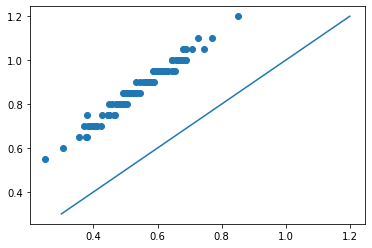

In [186]:
plt.scatter(mu_list, muhat_MLL_list)
plt.plot([0.3,1.2],[0.3,1.2])

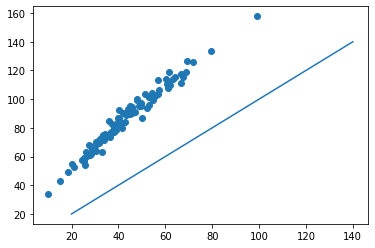

In [187]:
plt.scatter(q_muhat_new_list, q_muhat_MLL_list)
plt.plot([20,140],[20,140])

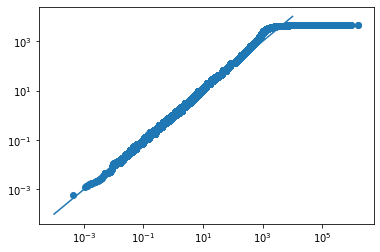

In [160]:
plt.scatter(pb_ps_exp, prob_x_given_B/prob_x_given_S)
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-4,1e4)
#plt.ylim(1e-4,1e4)
plt.plot([1e-4,1e4], [1e-4,1e4])

In [172]:
mu = find_mu(pb_ps_exp, S_expected, B_expected)
print("Valor de mu:", mu)

q_muhat_new =  2*(np.sum(np.log( 1 + ( (mu*S_expected/B_expected) / (pb_ps_exp)))) - mu*S_expected)
print(q_muhat_new)

Valor de mu: 0.44645641239308653
24.166161124378277


In [173]:
# approximation: mu_hat=1 (discovery)
q_muhat_MLL_mu_aprox = 2 * ( ( -1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) 
print(q_muhat_MLL_mu_aprox)

59.967517429790405


In [163]:
# ESTIMATE mu_hat for this particular ensemble (implicit equation)
B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

# reference points
sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


# we need (implicit eq. for mu_hat) = 1
# conditions considering the reference points
if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

    muhat_selected_MLL = 2.1

elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

    muhat_selected_MLL = -0.1

elif sum_muhat_zero < 1 < sum_muhat_two:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 > 1:
            muhat_selected_MLL = muhat_test[vv]
            break

elif sum_muhat_two < 1 < sum_muhat_zero:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 < 1:
            muhat_selected_MLL = muhat_test[vv]
            break


# save the computed mu_hat (within range) for each pseudo_experiment

print('muhat2', sum_muhat_two)
print('muhat0', sum_muhat_zero)
print(muhat_selected_MLL)


# compute the test statistic for each pseudo_exp considering mu_hat
q_muhat_MLL =  2 * ( (-1.*muhat_selected_MLL * S_expected) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) )
print(q_muhat_MLL)

                

muhat2 0.8961234816352464
muhat0 1.1638868810727716
0.8
63.66409979037803


0:10000
3 done
4 done
0.001721028958048736
0.001721028958048736
B_expected:  147986
S_expected:  641

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


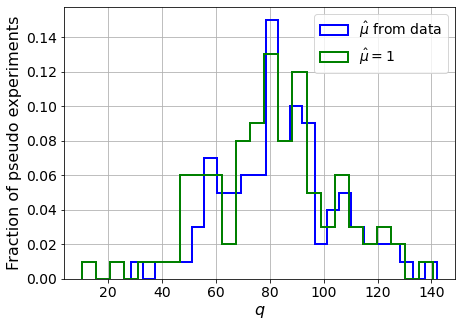

BP1
muhat mean:  0.8634999999999999
Z_MLL:  9.096951076680819
std Z_MLL:  1.138374475447136
Z_MLL mu=1:  8.980095994461541
std Z_MLL mu=1:  1.306797849416438

--------

1:10000
3 done
4 done
0.002030144740528514
0.002030144740528514
B_expected:  147986
S_expected:  582

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


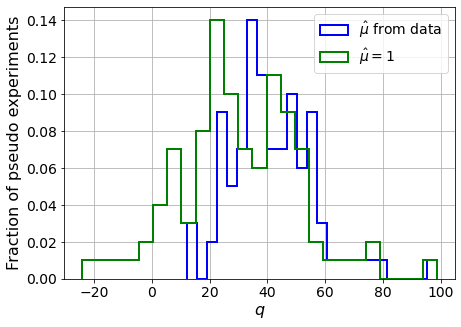

BP2
muhat mean:  0.6470000000000001
Z_MLL:  6.2861269460759335
std Z_MLL:  1.1457998889842997
Z_MLL mu=1:  5.414980994687844
std Z_MLL mu=1:  1.9011878352246527

--------

4:10000
3 done
4 done
0.002073417992791542
0.002073417992791542
B_expected:  147986
S_expected:  177

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


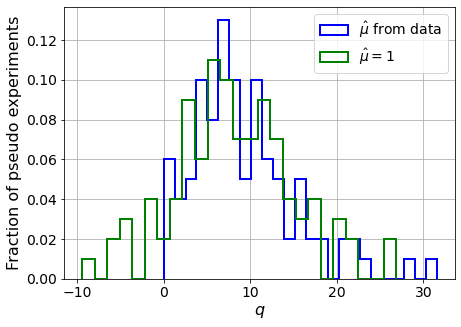

BP5
muhat mean:  0.853
Z_MLL:  2.8424321835072397
std Z_MLL:  1.0670429437461688
Z_MLL mu=1:  2.780341210288127
std Z_MLL mu=1:  1.2305447476669242

--------

7:10000
3 done
4 done
0.001864271943901527
0.001864271943901527
B_expected:  147986
S_expected:  107

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


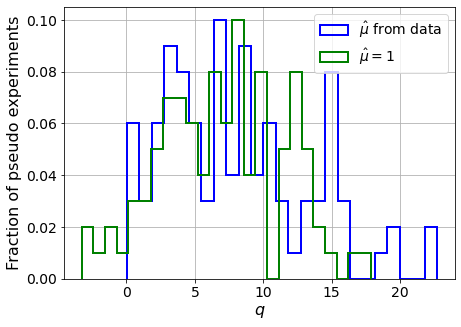

BP8
muhat mean:  1.241
Z_MLL:  2.687331059577332
std Z_MLL:  0.9798436365439029
Z_MLL mu=1:  2.657345857927333
std Z_MLL mu=1:  0.8466127214984356

--------



ValueError: 'a' cannot be empty unless no samples are taken

## Loop varying ML